<a href="https://colab.research.google.com/github/shoreey/Predicting-psychosis-vs-healthy-brain-with-computer-vision/blob/main/FEP_VS_HEALTHY_CONTROL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# MONAI imports
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    Resized,
    ToTensord,
    RandRotate90d,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandAffined,
    SpatialPadd,
)
from monai.data import Dataset as MonaiDataset
from monai.networks.nets import DenseNet121, ResNet
from monai.metrics import ROCAUCMetric, ConfusionMatrixMetric
from monai.utils import set_determinism
from monai.losses import FocalLoss
from monai.handlers import (
    StatsHandler,
    TensorBoardStatsHandler,
    CheckpointSaver,
    LrScheduleHandler,
)
from monai.engines import SupervisedTrainer, SupervisedEvaluator

# For splitting the dataset
from sklearn.model_selection import train_test_split

# For visualization
import nibabel as nib
from nilearn import plotting

# For tracking experiments
from tensorboard import program
import socket


import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import nibabel as nb
from torchvision import transforms
import torch
import torch.nn as nn
import math
from functools import partial
from torch.autograd import Variable

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
import datetime
import copy

In the future `np.object` will be defined as the corresponding NumPy scalar.
In the future `np.object` will be defined as the corresponding NumPy scalar.


In [ ]:
BASE_DIR="Data"
TRAIN_IMAGES_DIR=os.path.join(BASE_DIR,'train_images')

data_df=pd.read_excel("Classification_clean.xlsx")
data_df["Class"]=data_df["Diagnosis"]>0
#data_df["Class"].replace(True,2,inplace=True)
#data_df["Class"].replace(False,1,inplace=True)
data_df.Class = data_df.Class.astype('int')


data_df.head()

,ID_CF,Partition,FirstEpisodes_FEP__HealthyControl_HC_,Diagnosis,Gender,Age,Site 1,Site 2,Site 3,Site 4,Site 5,Site 6,Site 7,Euler,Class
0,CF_001,4,FEP,3,0,23.857632,0,0,0,0,0,0,0,-21,1
1,CF_002,5,FEP,3,0,28.952772,0,0,0,0,0,0,0,-33,1
2,CF_003,7,FEP,1,0,20.199863,0,0,0,0,0,0,0,-55,1
3,CF_004,6,FEP,1,0,28.517454,0,0,0,0,0,0,0,-26,1
4,CF_005,8,FEP,2,1,39.101985,0,0,0,0,0,0,0,-24,1


# Data Visualization

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674 entries, 0 to 673
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ID_CF                                  674 non-null    object 
 1   Partition                              674 non-null    int64  
 2   FirstEpisodes_FEP__HealthyControl_HC_  674 non-null    object 
 3   Diagnosis                              674 non-null    int64  
 4   Gender                                 674 non-null    int64  
 5   Age                                    674 non-null    float64
 6   Site 1                                 674 non-null    int64  
 7   Site 2                                 674 non-null    int64  
 8   Site 3                                 674 non-null    int64  
 9   Site 4                                 674 non-null    int64  
 10  Site 5                                 674 non-null    int64  
 11  Site 6

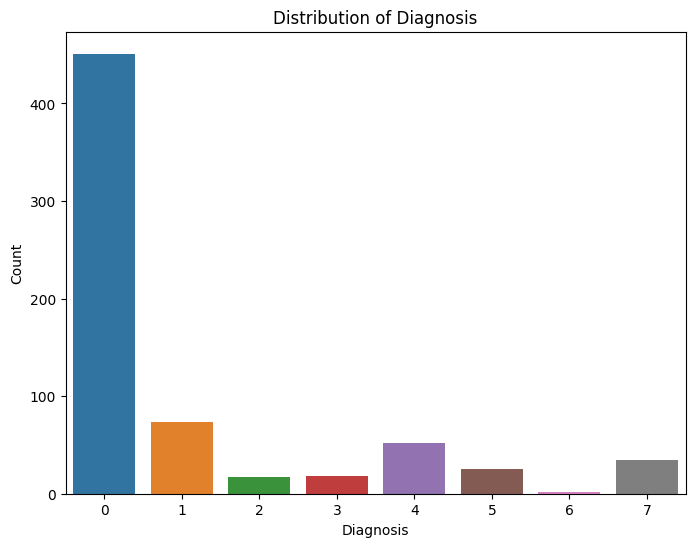

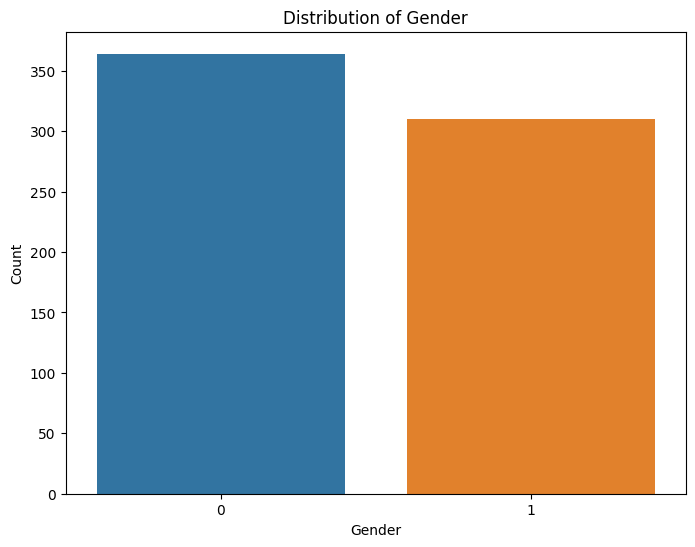

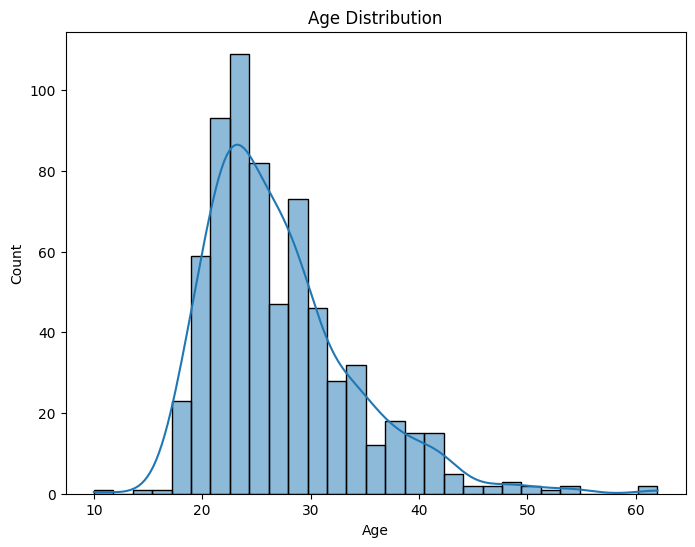

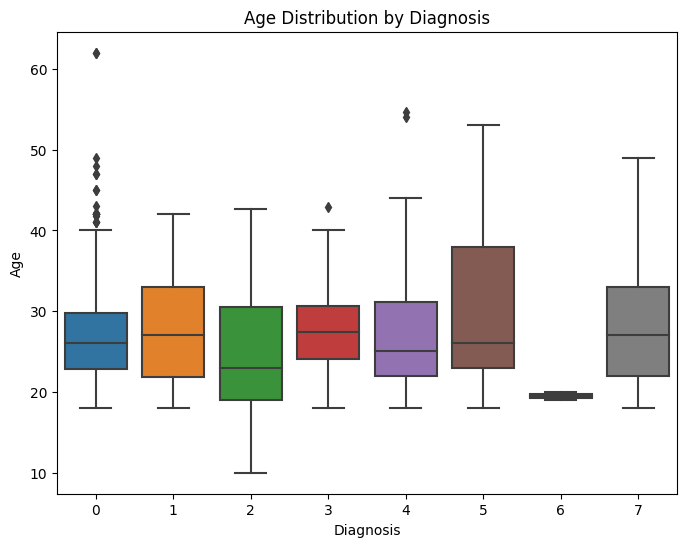

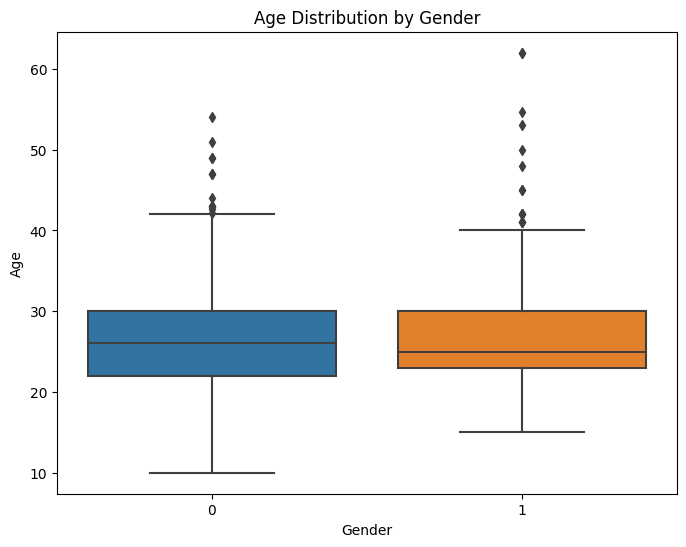

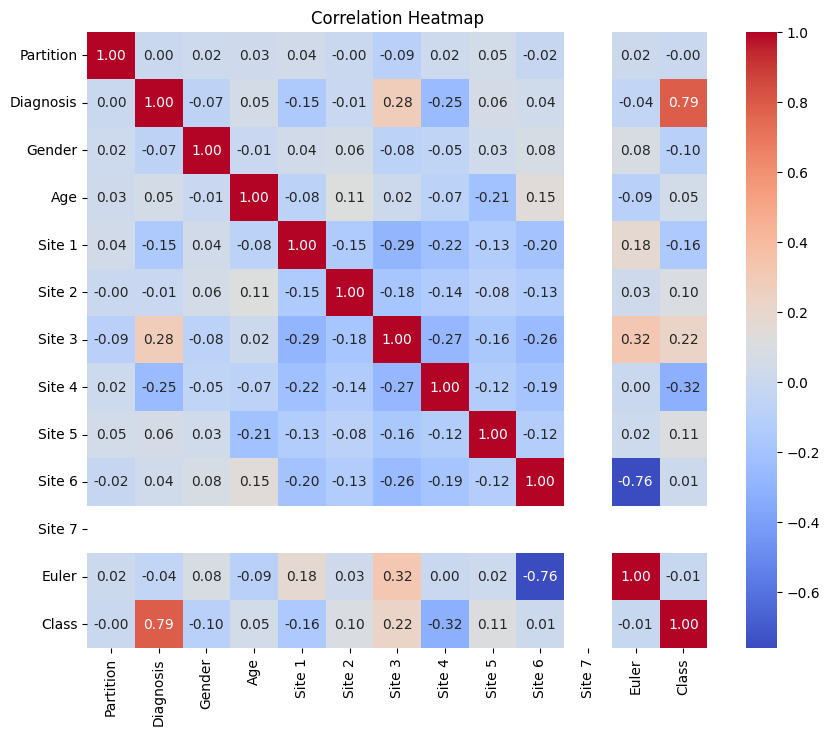

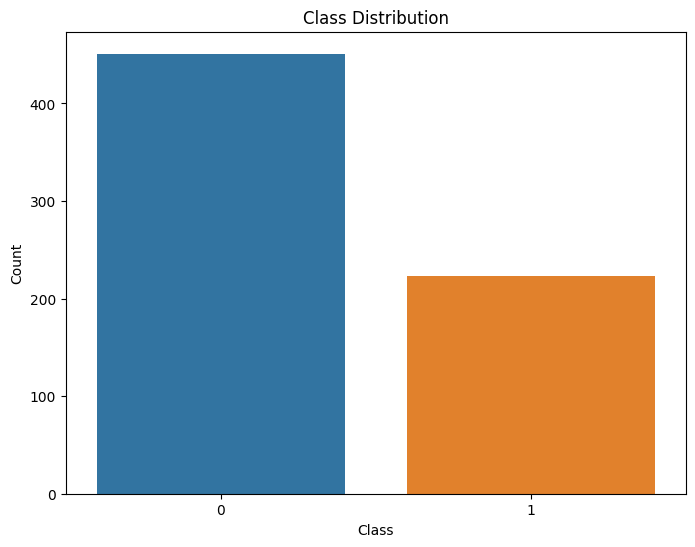


Diagnosis value counts:
Diagnosis
0    451
1     74
4     52
7     35
5     25
3     18
2     17
6      2
Name: count, dtype: int64

Gender value counts:
Gender
0    364
1    310
Name: count, dtype: int64

Class value counts:
Class
0    451
1    223
Name: count, dtype: int64

Age statistics:
count    674.000000
mean      27.138008
std        6.868340
min       10.000000
25%       22.000000
50%       26.000000
75%       30.000000
max       62.000000
Name: Age, dtype: float64

Correlation Matrix:
           Partition  Diagnosis    Gender       Age    Site 1    Site 2  \
Partition   1.000000   0.002044  0.019381  0.027589  0.038562 -0.000575   
Diagnosis   0.002044   1.000000 -0.065150  0.052768 -0.151310 -0.007157   
Gender      0.019381  -0.065150  1.000000 -0.005016  0.042183  0.056509   
Age         0.027589   0.052768 -0.005016  1.000000 -0.078564  0.114251   
Site 1      0.038562  -0.151310  0.042183 -0.078564  1.000000 -0.146417   
Site 2     -0.000575  -0.007157  0.056509  0.1142

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Print basic information about the dataset
print(data_df.info())
print("\nSummary statistics:")
print(data_df.describe())

# Plot 1: Distribution of Diagnosis (FEP vs Healthy Control)
plt.figure(figsize=(8, 6))
sns.countplot(data=data_df, x='Diagnosis')
plt.title('Distribution of Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

# Plot 2: Distribution of Gender
plt.figure(figsize=(8, 6))
sns.countplot(data=data_df, x='Gender')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Plot 3: Age distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=data_df, x='Age', kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Plot 4: Box plot of Age grouped by Diagnosis
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_df, x='Diagnosis', y='Age')
plt.title('Age Distribution by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Age')
plt.show()

# Plot 5: Box plot of Age grouped by Gender
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_df, x='Gender', y='Age')
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

# Exclude non-numeric columns
numeric_data_df = data_df.select_dtypes(include=['number'])

# Plot 6: Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Plot 7: Class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data_df, x='Class')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Print additional information
print("\nDiagnosis value counts:")
print(data_df['Diagnosis'].value_counts())

print("\nGender value counts:")
print(data_df['Gender'].value_counts())

print("\nClass value counts:")
print(data_df['Class'].value_counts())

print("\nAge statistics:")
print(data_df['Age'].describe())

# Print the correlation matrix
print("\nCorrelation Matrix:")
corr_matrix = numeric_data_df.corr()
# Set pandas display options to show full matrix
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print(corr_matrix)

# Reset pandas display options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

# Diagnosis Analysis

Diagnosis counts by site:
   Site 1  Site 2  Site 3  Site 4  Site 5  Site 6  Site 7
3       0       0      11       0       1       0       0
1      10      14      21       0       7      15       0
2       2       5       2       0       5       0       0
4       8       7      24       0       7       0       0
5       0       2       7       0       1      14       0
0     103      30      89     115      22      68       0
7       2       0      25       0       1       7       0
6       0       0       0       0       2       0       0


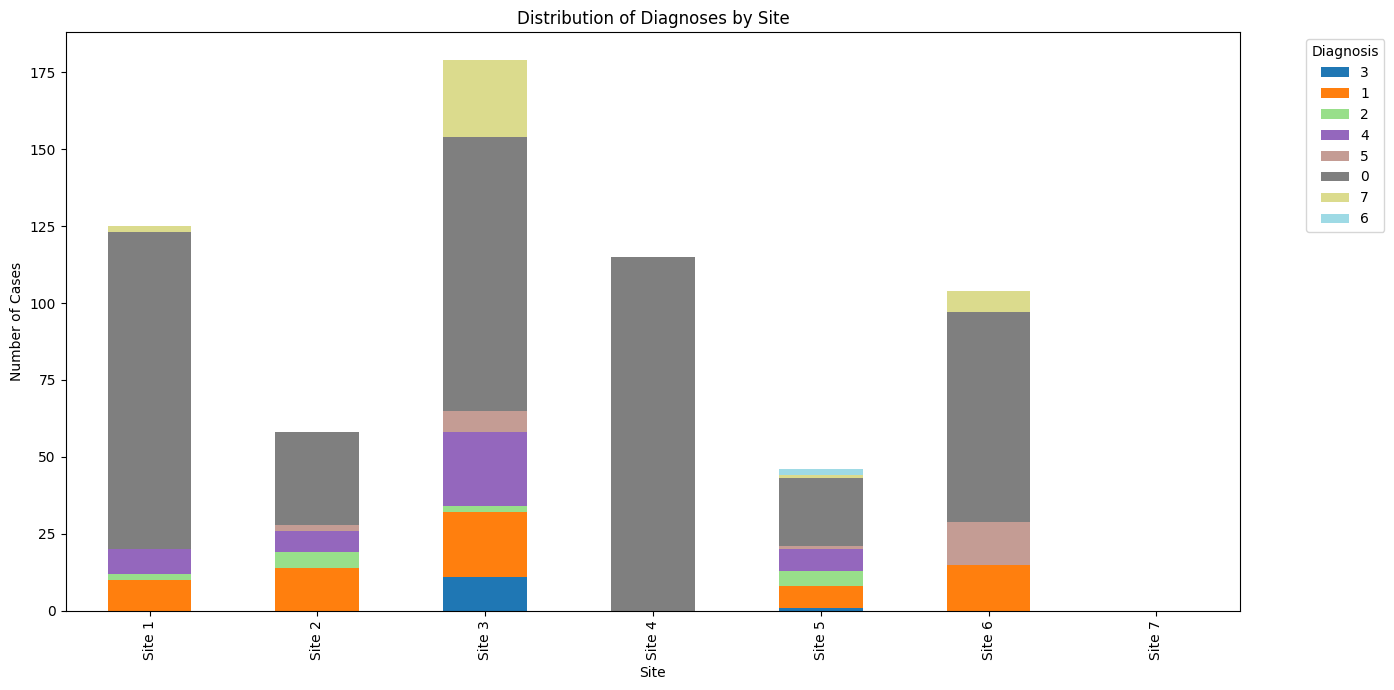

In [ ]:
# Initialize a dictionary to store diagnosis counts by site
diagnosis_counts_by_site = {f'Site {i}': {} for i in range(1, 8)}

# Iterate through each site column and count diagnoses
for site in diagnosis_counts_by_site.keys():
    for diagnosis in data_df['Diagnosis'].unique():
        diagnosis_counts_by_site[site][diagnosis] = data_df[(data_df[site] == 1) & (data_df['Diagnosis'] == diagnosis)].shape[0]

# Convert the dictionary to a DataFrame for easier visualization
diagnosis_counts_df = pd.DataFrame(diagnosis_counts_by_site).fillna(0).astype(int)

# Display the counts
print("Diagnosis counts by site:")
print(diagnosis_counts_df)

import matplotlib.pyplot as plt

# Plot the diagnosis counts by site
diagnosis_counts_df.T.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')
plt.title('Distribution of Diagnoses by Site')
plt.xlabel('Site')
plt.ylabel('Number of Cases')
plt.legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Count the Number of FEP Count VS Healthy Count With Respect to the Sites

In [ ]:
# Count the number of FEP and HC cases
class_counts = data_df['Class'].value_counts()

# Print the counts
print("Number of FEP cases:", class_counts[1])
print("Number of HC cases:", class_counts[0])
# Group by Class and Site columns and count the occurrences
site_columns = ['Site 1', 'Site 2', 'Site 3', 'Site 4', 'Site 5', 'Site 6', 'Site 7']
fep_counts_by_site = data_df[data_df['Class'] == 1][site_columns].sum()
hc_counts_by_site = data_df[data_df['Class'] == 0][site_columns].sum()

# Print the counts by site
print("FEP counts by site:")
print(fep_counts_by_site)

print("\nHC counts by site:")
print(hc_counts_by_site)

Number of FEP cases: 223
Number of HC cases: 451
FEP counts by site:
Site 1    22
Site 2    28
Site 3    90
Site 4     0
Site 5    24
Site 6    36
Site 7     0
dtype: int64

HC counts by site:
Site 1    103
Site 2     30
Site 3     89
Site 4    115
Site 5     22
Site 6     68
Site 7      0
dtype: int64


# Visualization to Understand it better

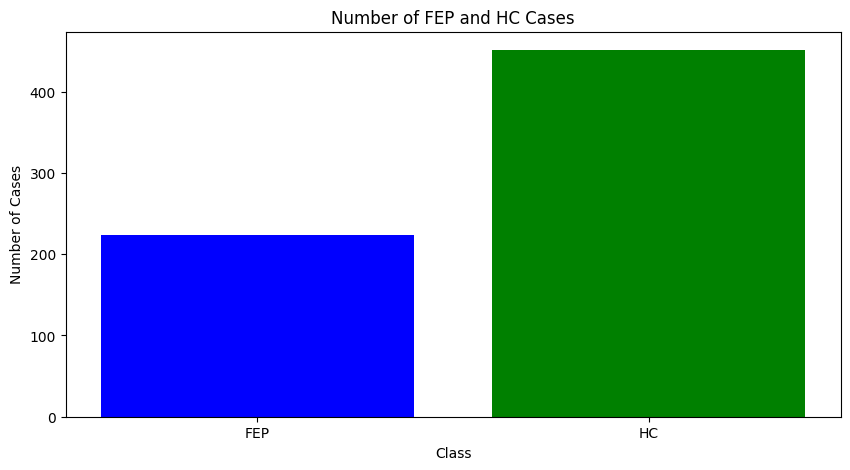

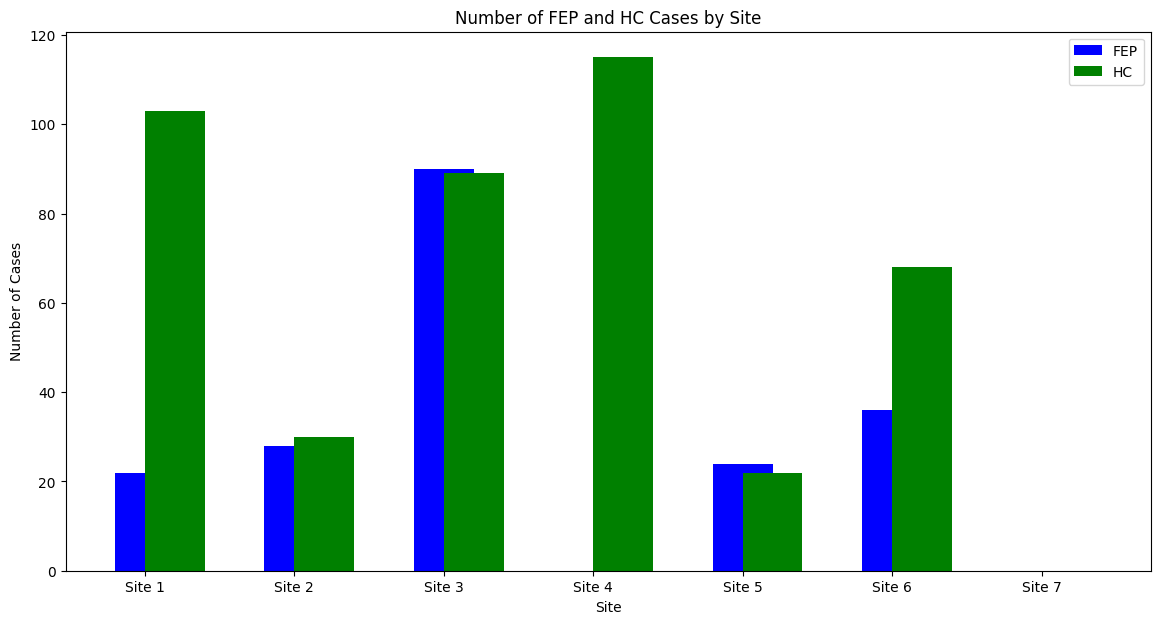

In [ ]:

# Group by Class and Site columns and count the occurrences
site_columns = ['Site 1', 'Site 2', 'Site 3', 'Site 4', 'Site 5', 'Site 6', 'Site 7']
fep_counts_by_site = data_df[data_df['Class'] == 1][site_columns].sum()
hc_counts_by_site = data_df[data_df['Class'] == 0][site_columns].sum()

# Plot overall FEP and HC counts
plt.figure(figsize=(10, 5))
plt.bar(['FEP', 'HC'], [class_counts[1], class_counts[0]], color=['blue', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Cases')
plt.title('Number of FEP and HC Cases')
plt.show()

# Plot FEP and HC counts by site
x = range(len(site_columns))

plt.figure(figsize=(14, 7))
plt.bar(x, fep_counts_by_site, width=0.4, label='FEP', color='blue', align='center')
plt.bar(x, hc_counts_by_site, width=0.4, label='HC', color='green', align='edge')
plt.xlabel('Site')
plt.ylabel('Number of Cases')
plt.title('Number of FEP and HC Cases by Site')
plt.xticks(x, site_columns)
plt.legend()
plt.show()

# Count FEP Vs HC Cases by Gender

Counts of FEP and HC cases by Gender:
Gender    0    1
Class           
0       228  223
1       136   87

Total counts by Class:
Class
0    451
1    223
dtype: int64


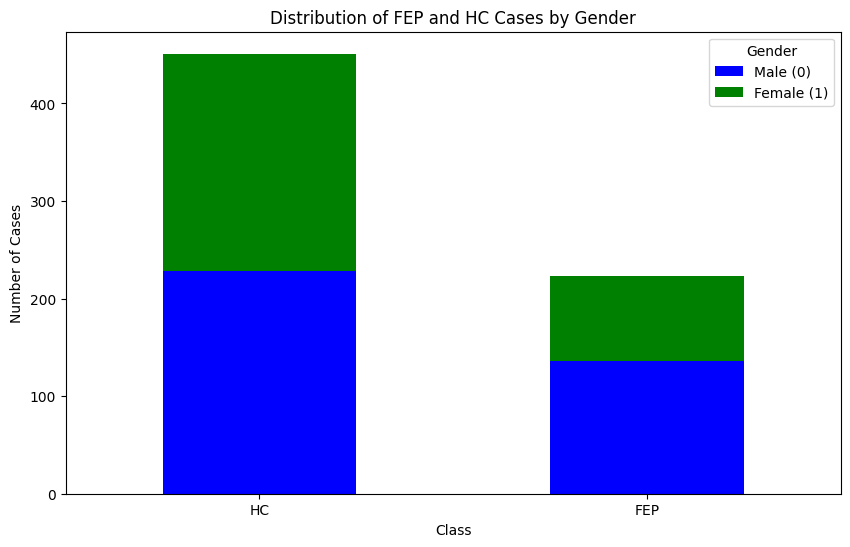

In [ ]:
# Count FEP and HC cases by Gender
gender_counts = data_df.groupby(['Class', 'Gender']).size().unstack(fill_value=0)

# Display the counts
print("Counts of FEP and HC cases by Gender:")
print(gender_counts)

# Calculate total counts
total_counts = gender_counts.sum(axis=1)
print("\nTotal counts by Class:")
print(total_counts)

import matplotlib.pyplot as plt

# Plot the counts of FEP and HC cases by Gender
gender_counts.plot(kind='bar', stacked=True, color=['blue', 'green'], figsize=(10, 6))
plt.title('Distribution of FEP and HC Cases by Gender')
plt.xlabel('Class')
plt.ylabel('Number of Cases')
plt.xticks(ticks=[0, 1], labels=['HC', 'FEP'], rotation=0)
plt.legend(['Male (0)', 'Female (1)'], title='Gender')
plt.show()

In [ ]:
class Milano_MRI_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms=None):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms

        # Filter out records with missing files or empty files
        self.df = self.df[self.df['ID_CF'].apply(lambda x: os.path.exists(os.path.join(imfolder, f'w{x}_MRI_sMRI_{x}_brain.nii.gz'))
                                                  and os.path.getsize(os.path.join(imfolder, f'w{x}_MRI_sMRI_{x}_brain.nii.gz')) > 0)]

    def __getitem__(self, index):
        filename = f'w{self.df.iloc[index]["ID_CF"]}_MRI_sMRI_{self.df.iloc[index]["ID_CF"]}_brain.nii.gz'
        im_path = os.path.join(self.imfolder, filename)

        # Check if file exists and is non-empty
        if os.path.exists(im_path) and os.path.getsize(im_path) > 0:
            nimg = nb.load(im_path)
            x = np.array(nimg.dataobj)
            x = transforms.ToTensor()(x)
            x = x.unsqueeze(0).type(torch.FloatTensor)
            m = torch.mean(x)
            s = torch.std(x)
            x = (x - m) / s

            if self.train:
                y = self.df.iloc[index]['Class']
                return x, y
            else:
                return x
        else:
            # Handle empty file, return None or some placeholder data
            return None

    def __len__(self):
        return len(self.df)


In [ ]:
train, valid = train_test_split(
    data_df,
    test_size=0.2,
    random_state=42,
    stratify=data_df.Class.values
)



# reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

train_targets = train.Class.values

# targets for validation
valid_targets = valid.Class.values

train_dataset=Milano_MRI_Dataset(
    df=train,
    imfolder=BASE_DIR,
    train=True,
    transforms=None
)

valid_dataset=Milano_MRI_Dataset(
    df=valid,
    imfolder=BASE_DIR,
    train=True,
    transforms=None
)

train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    #num_workers=4,
    shuffle=True,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=15,
    #num_workers=4,
    shuffle=False,
)

Epoch 0/9
----------
train Loss: 0.7732 Acc: 0.5591 AUC: 0.5368
valid Loss: 0.6366 Acc: 0.6260 AUC: 0.6416

Epoch 1/9
----------
train Loss: 0.7046 Acc: 0.6060 AUC: 0.6241
valid Loss: 0.6905 Acc: 0.5420 AUC: 0.5716

Epoch 2/9
----------
train Loss: 0.7031 Acc: 0.6023 AUC: 0.6199
valid Loss: 0.6726 Acc: 0.5725 AUC: 0.6080

Epoch 3/9
----------
train Loss: 0.6943 Acc: 0.5966 AUC: 0.6355
valid Loss: 0.6816 Acc: 0.5573 AUC: 0.6057

Epoch 4/9
----------
train Loss: 0.6781 Acc: 0.6154 AUC: 0.6426
valid Loss: 0.6702 Acc: 0.5725 AUC: 0.5972

Epoch 5/9
----------
train Loss: 0.6984 Acc: 0.5779 AUC: 0.6241
valid Loss: 0.6648 Acc: 0.5649 AUC: 0.6070

Epoch 6/9
----------
train Loss: 0.7033 Acc: 0.5854 AUC: 0.6166
valid Loss: 0.6786 Acc: 0.5725 AUC: 0.5969

Epoch 7/9
----------
train Loss: 0.6906 Acc: 0.6060 AUC: 0.6154
valid Loss: 0.6870 Acc: 0.5802 AUC: 0.5941

Epoch 8/9
----------
train Loss: 0.7070 Acc: 0.5797 AUC: 0.6116
valid Loss: 0.6757 Acc: 0.5878 AUC: 0.6059

Epoch 9/9
----------
train L

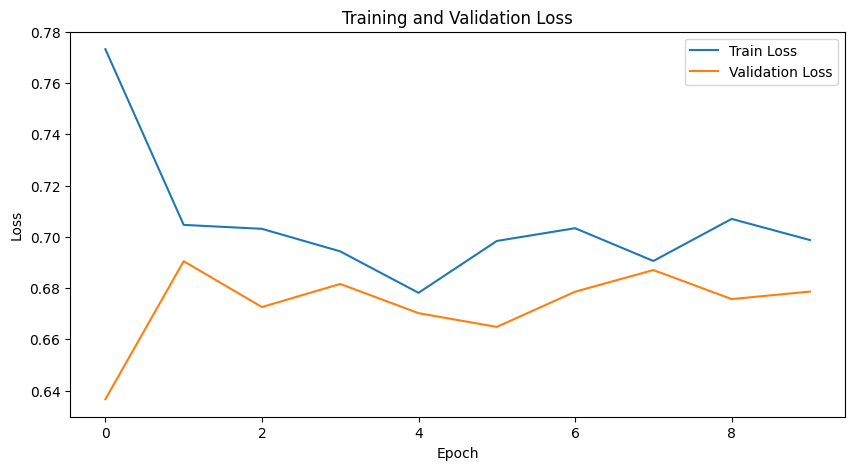

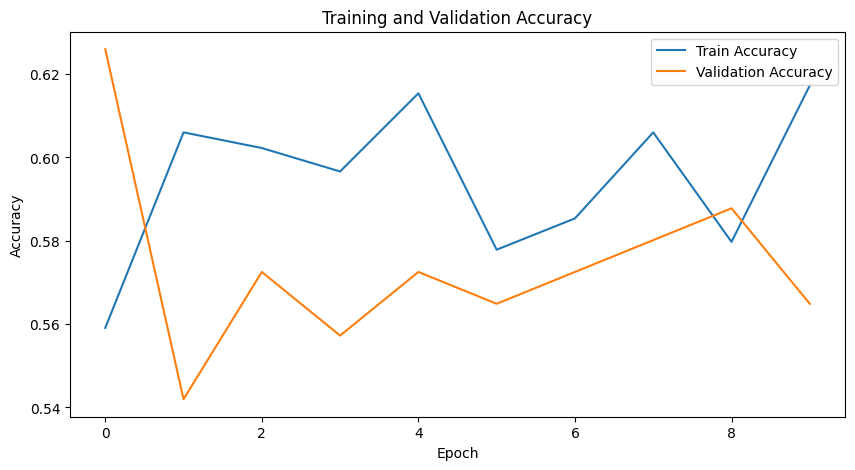

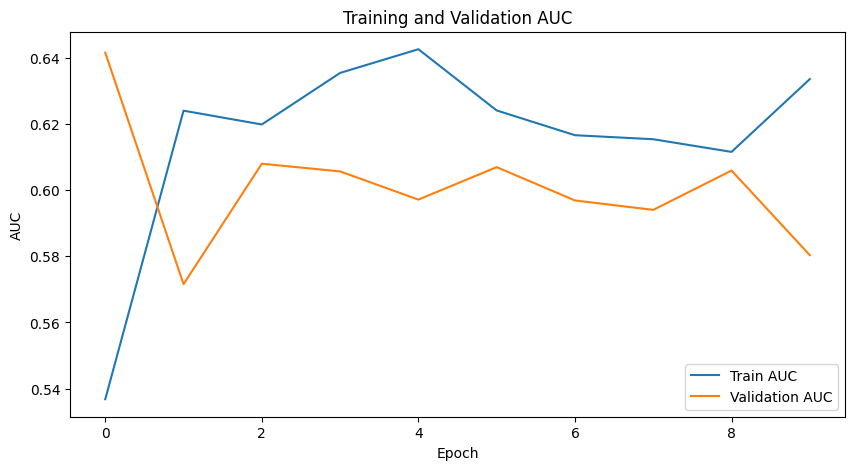

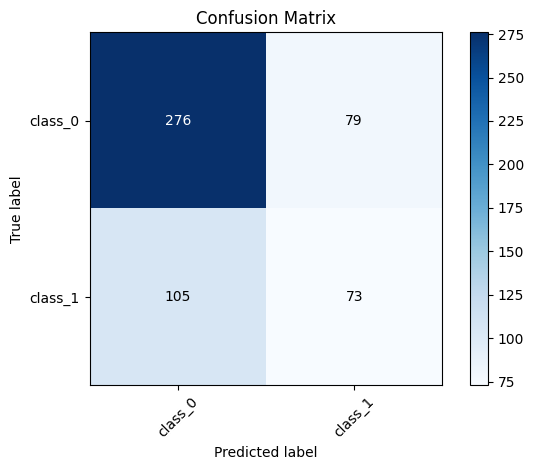

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import copy
import time

# Define the model class
class FEP_HC(nn.Module):
    def __init__(self, num_classes):
        super(Simple3DCNN, self).__init__()

        self.conv_layer1 = self._make_conv_layer(1, 32)
        self.conv_layer2 = self._make_conv_layer(32, 64)
        self.conv_layer3 = self._make_conv_layer(64, 128)
        self.conv_layer4 = self._make_conv_layer(128, 256)
        self.conv_layer5 = nn.Conv3d(256, 2048, kernel_size=(4, 4, 5), padding=0)

        self.fc5 = nn.Linear(2048, 512)
        self.relu = nn.LeakyReLU()
        self.batch0 = nn.BatchNorm1d(512)
        self.drop = nn.Dropout(p=0.25)
        self.fc6 = nn.Linear(512, 256)
        self.relu = nn.LeakyReLU()
        self.batch1 = nn.BatchNorm1d(256)

        self.drop = nn.Dropout(p=0.25)
        self.fc7 = nn.Linear(256, num_classes)

    def _make_conv_layer(self, in_c, out_c):
        conv_layer = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm3d(out_c),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )
        return conv_layer

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.batch0(x)
        x = self.drop(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.batch1(x)
        x = self.drop(x)
        x = self.fc7(x)
        return x

# Define other parameters
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight = torch.from_numpy(weight)
class_weight = class_weight.max() / class_weight
class_weight = class_weight / class_weight.max()
class_weight = class_weight.type(torch.FloatTensor)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datasets = {'train': train_dataset, 'valid': valid_dataset}
dataloaders = {'train': train_loader, 'valid': valid_loader}

# Define the model
model = FEP_HC(2)

# Define the optimizer with the desired parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.001)

# Adjust the step size for the scheduler for training only 10 epochs
step_size = 1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

criterion = nn.CrossEntropyLoss()

num_epochs = 10

# Define functions for training and plotting confusion matrix
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accuracies = []
    train_aucs = []
    val_losses = []
    val_accuracies = []
    val_aucs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            all_labels = []
            all_preds = []
            all_probs = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out the grads
                optimizer.zero_grad()

                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.type(torch.LongTensor).to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(outputs[:, 1].detach().cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            epoch_auc = roc_auc_score(all_labels, all_probs)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
                train_aucs.append(epoch_auc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                val_aucs.append(epoch_auc)

            print('{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_auc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation AUCs
    plt.figure(figsize=(10, 5))
    plt.plot(train_aucs, label='Train AUC')
    plt.plot(val_aucs, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.legend()
    plt.show()

    return model

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Train the model
trained_model = train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device)

# Get predictions for the entire dataset (including validation)
all_predictions = []
all_targets = []
for inputs, labels in dataloaders['train']:  # Use the train loader for the entire dataset
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = trained_model(inputs)
    _, preds = torch.max(outputs, 1)
    all_predictions.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())

# Compute confusion matrix for the entire dataset
cm = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix
plot_confusion_matrix(cm, classes=['class_0', 'class_1'], title='Confusion Matrix')

plt.show()


# ALexNet

Epoch 0/9
----------
train Loss: 0.7123 Acc: 0.3415 AUC: 0.4616
valid Loss: 0.7009 Acc: 0.3435 AUC: 0.4473

Epoch 1/9
----------
train Loss: 0.7054 Acc: 0.3527 AUC: 0.5064
valid Loss: 0.6997 Acc: 0.3435 AUC: 0.4408

Epoch 2/9
----------
train Loss: 0.7040 Acc: 0.3696 AUC: 0.5140
valid Loss: 0.6996 Acc: 0.3435 AUC: 0.4395

Epoch 3/9
----------
train Loss: 0.7027 Acc: 0.3583 AUC: 0.5366
valid Loss: 0.6996 Acc: 0.3435 AUC: 0.4398

Epoch 4/9
----------
train Loss: 0.7049 Acc: 0.3583 AUC: 0.5060
valid Loss: 0.6996 Acc: 0.3435 AUC: 0.4398

Epoch 5/9
----------
train Loss: 0.7044 Acc: 0.3508 AUC: 0.4824
valid Loss: 0.6996 Acc: 0.3435 AUC: 0.4398

Epoch 6/9
----------
train Loss: 0.7042 Acc: 0.3752 AUC: 0.4625
valid Loss: 0.6996 Acc: 0.3435 AUC: 0.4398

Epoch 7/9
----------
train Loss: 0.7054 Acc: 0.3452 AUC: 0.4738
valid Loss: 0.6996 Acc: 0.3435 AUC: 0.4398

Epoch 8/9
----------
train Loss: 0.7044 Acc: 0.3565 AUC: 0.4731
valid Loss: 0.6996 Acc: 0.3435 AUC: 0.4398

Epoch 9/9
----------
train L

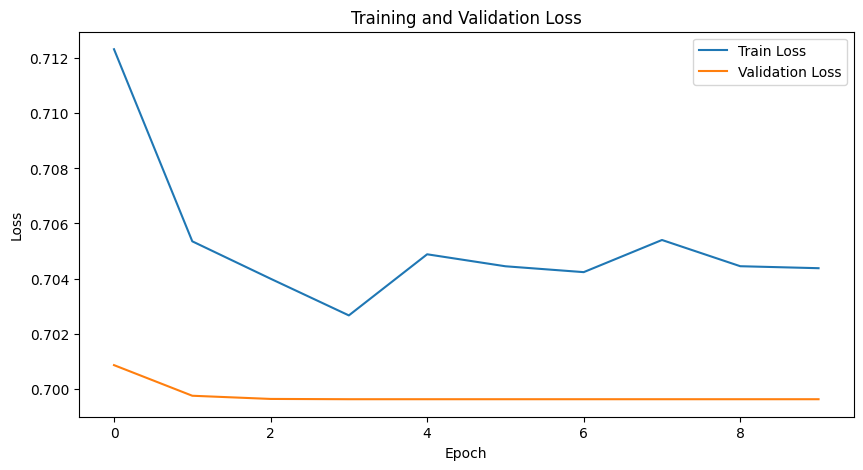

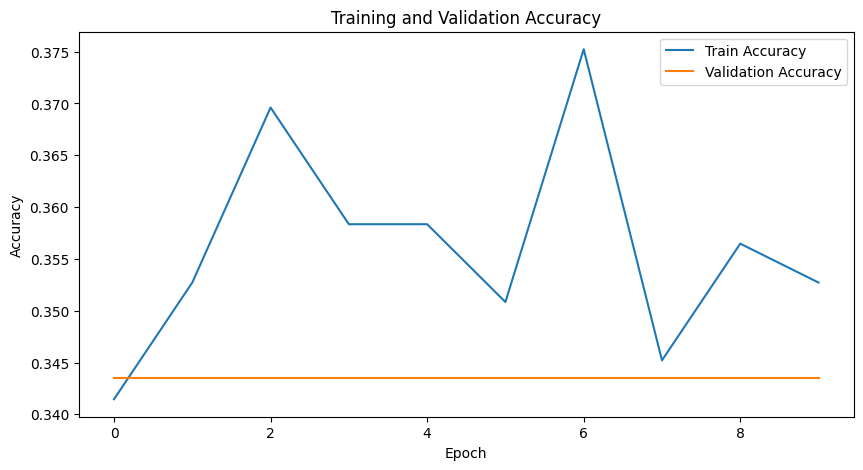

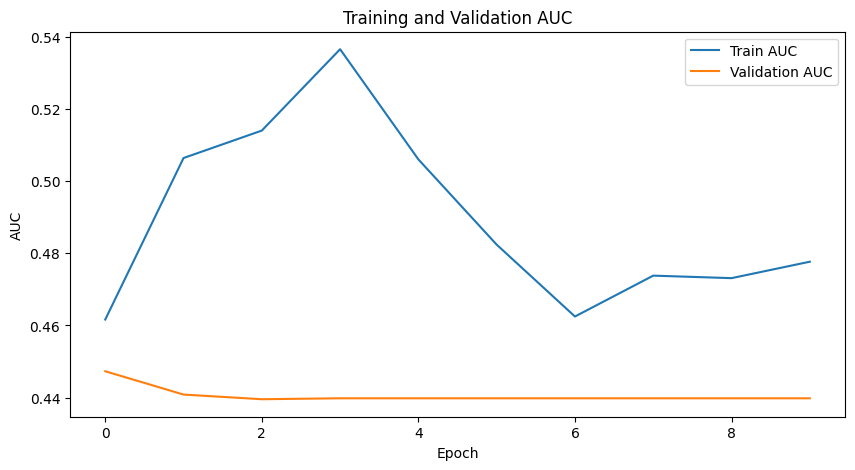

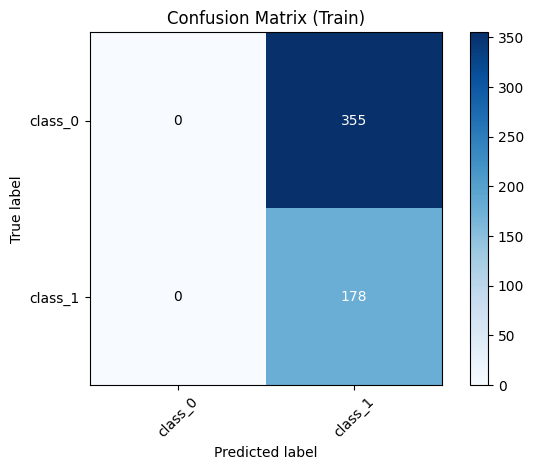

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import copy
import time

# Define the model class
class AlexNet_3D(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet_3D, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv3d(1, 144, kernel_size=5, stride=2),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=3, stride=2),
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv3d(144, 192, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=3, stride=2),
        )

        self.conv_layer3 = nn.Sequential(
            nn.Conv3d(192, 192, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=3, stride=2),
            nn.Dropout(p=0.4)
        )

        self.fc1 = nn.Linear(2304, 374)
        self.relu1 = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.4)

        self.fc2 = nn.Linear(374, 192)
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(192, num_classes)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)

        return x

# Define other parameters
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight = torch.from_numpy(weight)
class_weight = class_weight.max() / class_weight
class_weight = class_weight / class_weight.max()
class_weight = class_weight.type(torch.FloatTensor)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datasets = {'train': train_dataset, 'valid': valid_dataset}
dataloaders = {'train': train_loader, 'valid': valid_loader}

# Define the model
model = AlexNet_3D(2)

# Define the optimizer with the desired parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.001)

# Adjust the step size for the scheduler for training only 10 epochs
step_size = 1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

criterion = nn.CrossEntropyLoss()

num_epochs = 10

# Define functions for training and plotting confusion matrix
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accuracies = []
    train_aucs = []
    val_losses = []
    val_accuracies = []
    val_aucs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            all_labels = []
            all_preds = []
            all_probs = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out the grads
                optimizer.zero_grad()

                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.type(torch.LongTensor).to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(outputs[:, 1].detach().cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            epoch_auc = roc_auc_score(all_labels, all_probs)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
                train_aucs.append(epoch_auc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                val_aucs.append(epoch_auc)

            print('{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_auc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation AUCs
    plt.figure(figsize=(10, 5))
    plt.plot(train_aucs, label='Train AUC')
    plt.plot(val_aucs, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.legend()
    plt.show()

    return model

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



# Train the model
trained_model = train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device)

# Get predictions for the entire dataset (training set only)
all_predictions = []
all_targets = []
all_probs = []

for inputs, labels in dataloaders['train']:  # Use the train loader for the entire dataset
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = trained_model(inputs)
    _, preds = torch.max(outputs, 1)
    all_predictions.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())
    all_probs.extend(outputs[:, 1].detach().cpu().numpy())

# Compute confusion matrix for the entire dataset
cm_train = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix for training set
plot_confusion_matrix(cm_train, classes=['class_0', 'class_1'], title='Confusion Matrix (Train)')

plt.show()


# VOXCNN

Epoch 0/9
----------
train Loss: 0.6909 Acc: 0.6773 AUC: 0.5869
valid Loss: 0.6913 Acc: 0.6565 AUC: 0.6829

Epoch 1/9
----------
train Loss: 0.6906 Acc: 0.6623 AUC: 0.6103
valid Loss: 0.6912 Acc: 0.6565 AUC: 0.6809

Epoch 2/9
----------
train Loss: 0.6907 Acc: 0.6735 AUC: 0.6088
valid Loss: 0.6910 Acc: 0.6565 AUC: 0.6822

Epoch 3/9
----------
train Loss: 0.6906 Acc: 0.6754 AUC: 0.6095
valid Loss: 0.6908 Acc: 0.6565 AUC: 0.6832

Epoch 4/9
----------
train Loss: 0.6906 Acc: 0.6623 AUC: 0.5941
valid Loss: 0.6908 Acc: 0.6565 AUC: 0.6832

Epoch 5/9
----------
train Loss: 0.6905 Acc: 0.6698 AUC: 0.6516
valid Loss: 0.6907 Acc: 0.6565 AUC: 0.6829

Epoch 6/9
----------
train Loss: 0.6908 Acc: 0.6698 AUC: 0.5825
valid Loss: 0.6908 Acc: 0.6565 AUC: 0.6829

Epoch 7/9
----------
train Loss: 0.6905 Acc: 0.6660 AUC: 0.5834
valid Loss: 0.6907 Acc: 0.6565 AUC: 0.6829

Epoch 8/9
----------
train Loss: 0.6907 Acc: 0.6604 AUC: 0.6061
valid Loss: 0.6908 Acc: 0.6565 AUC: 0.6829

Epoch 9/9
----------
train L

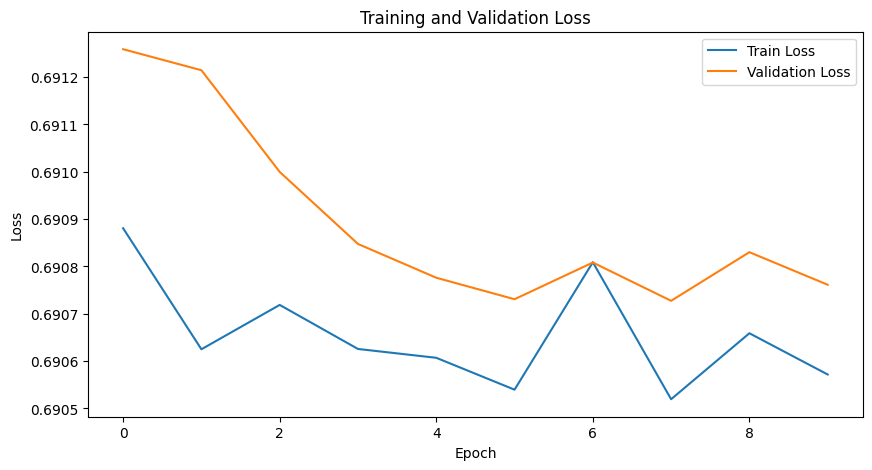

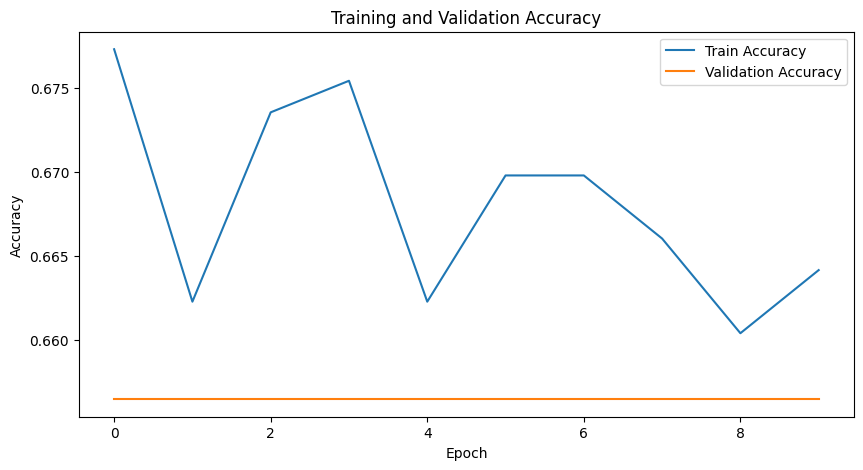

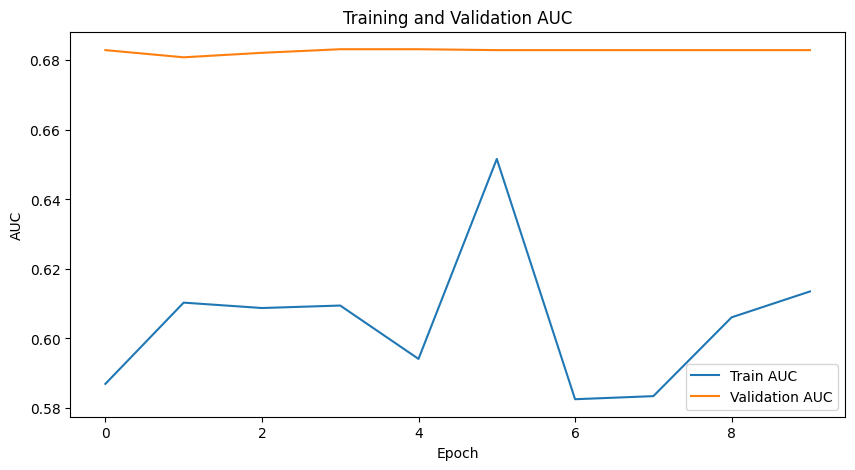

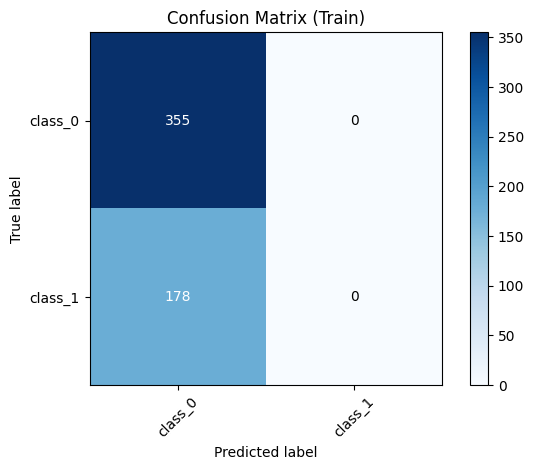

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import copy
import time

# Define the model class
class VoxCNN(nn.Module):

    def __init__(self, num_classes):
        super(VoxCNN, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv3d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )

        self.conv_layer3 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )

        self.conv_layer4 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )

        self.class_layer = nn.Sequential(
            nn.Linear(5120, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.7),
            nn.Linear(128, 64),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = x.view(x.size(0), -1)
        x = self.class_layer(x)
        return x

# Define other parameters
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight = torch.from_numpy(weight)
class_weight = class_weight.max() / class_weight
class_weight = class_weight / class_weight.max()
class_weight = class_weight.type(torch.FloatTensor)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datasets = {'train': train_dataset, 'valid': valid_dataset}
dataloaders = {'train': train_loader, 'valid': valid_loader}

# Define the model
model = VoxCNN(2)

# Define the optimizer with the desired parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.001)

# Adjust the step size for the scheduler for training only 10 epochs
step_size = 1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

criterion = nn.CrossEntropyLoss()

num_epochs = 10

# Define functions for training and plotting confusion matrix
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accuracies = []
    train_aucs = []
    val_losses = []
    val_accuracies = []
    val_aucs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            all_labels = []
            all_preds = []
            all_probs = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out the grads
                optimizer.zero_grad()

                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.type(torch.LongTensor).to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(outputs[:, 1].detach().cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            epoch_auc = roc_auc_score(all_labels, all_probs)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
                train_aucs.append(epoch_auc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                val_aucs.append(epoch_auc)

            print('{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_auc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation AUCs
    plt.figure(figsize=(10, 5))
    plt.plot(train_aucs, label='Train AUC')
    plt.plot(val_aucs, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.legend()
    plt.show()

    return model

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



# Train the model
trained_model = train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device)

# Get predictions for the entire dataset (training set only)
all_predictions = []
all_targets = []
all_probs = []

for inputs, labels in dataloaders['train']:  # Use the train loader for the entire dataset
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = trained_model(inputs)
    _, preds = torch.max(outputs, 1)
    all_predictions.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())
    all_probs.extend(outputs[:, 1].detach().cpu().numpy())

# Compute confusion matrix for the entire dataset
cm_train = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix for training set
plot_confusion_matrix(cm_train, classes=['class_0', 'class_1'], title='Confusion Matrix (Train)')

plt.show()


# Updated Alexnet 3D

Epoch 0/19
----------
train Loss: 0.5074 Acc: 0.6604 AUC: 0.6209
valid Loss: 0.5141 Acc: 0.6565 AUC: 0.6155

Epoch 1/19
----------
train Loss: 0.5103 Acc: 0.6642 AUC: 0.6095
valid Loss: 0.4955 Acc: 0.6565 AUC: 0.6426

Epoch 2/19
----------
train Loss: 0.4725 Acc: 0.6642 AUC: 0.6746
valid Loss: 0.4896 Acc: 0.6565 AUC: 0.6594

Epoch 3/19
----------
train Loss: 0.4949 Acc: 0.6679 AUC: 0.6434
valid Loss: 0.4845 Acc: 0.6565 AUC: 0.6674

Epoch 4/19
----------
train Loss: 0.4784 Acc: 0.6679 AUC: 0.6826
valid Loss: 0.4813 Acc: 0.6565 AUC: 0.6801

Epoch 5/19
----------
train Loss: 0.4649 Acc: 0.6660 AUC: 0.6839
valid Loss: 0.4876 Acc: 0.6947 AUC: 0.6961

Epoch 6/19
----------
train Loss: 0.4734 Acc: 0.6754 AUC: 0.6840
valid Loss: 0.4963 Acc: 0.6565 AUC: 0.6943

Epoch 7/19
----------
train Loss: 0.4634 Acc: 0.6623 AUC: 0.7189
valid Loss: 0.4821 Acc: 0.6794 AUC: 0.6855

Epoch 8/19
----------
train Loss: 0.4354 Acc: 0.6923 AUC: 0.7557
valid Loss: 0.5720 Acc: 0.6565 AUC: 0.7021

Epoch 9/19
--------

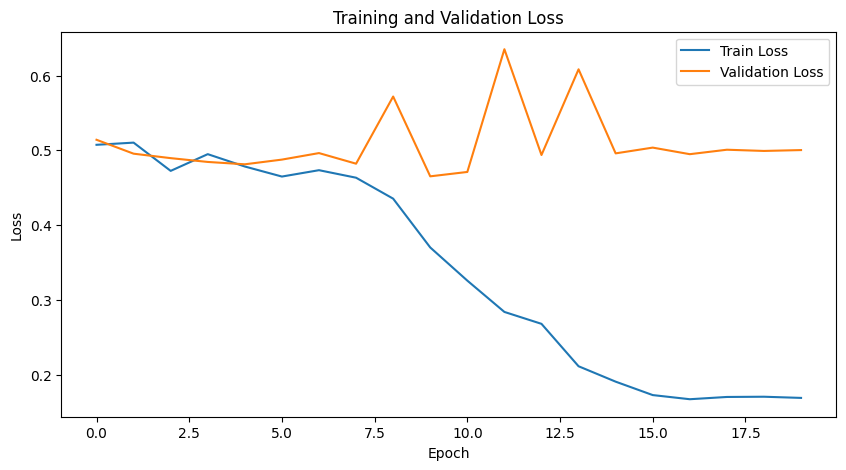

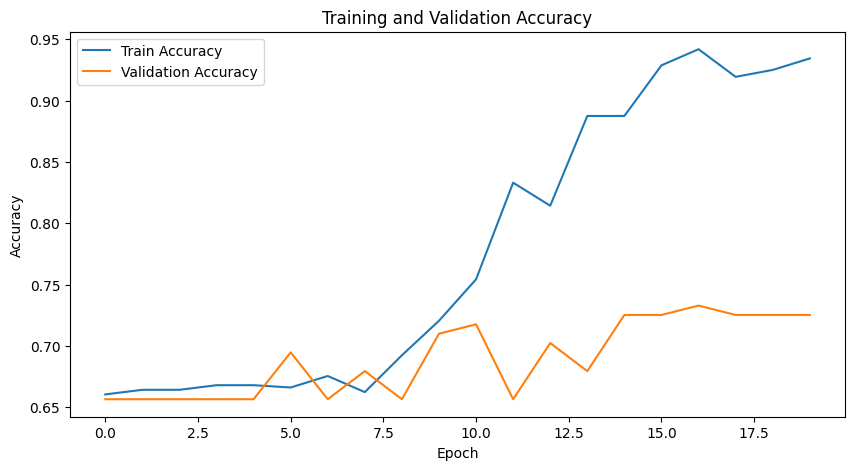

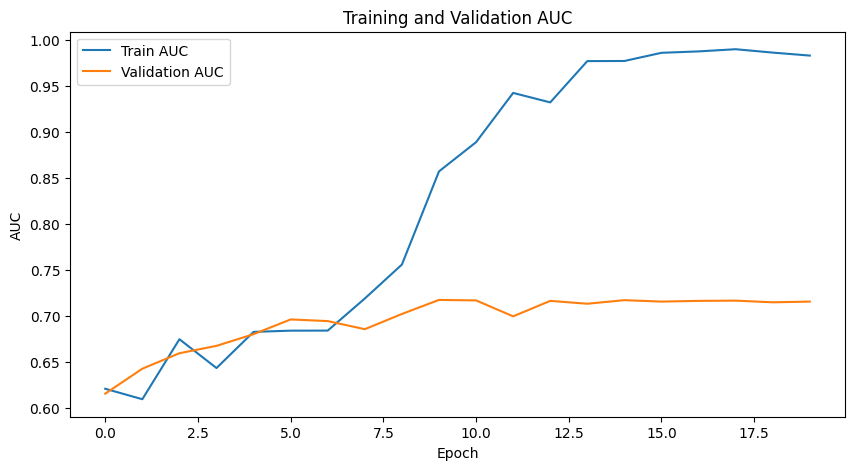

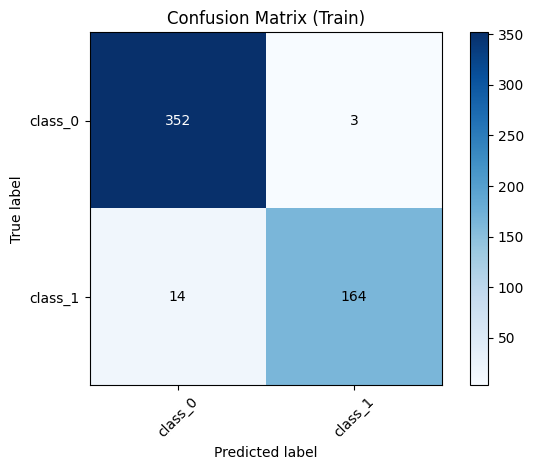

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import copy
import time

# Define the model class with updated architecture and Batch Normalization
class AlexNet_3D(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet_3D, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv3d(1, 144, kernel_size=5, stride=2),
            nn.BatchNorm3d(144),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=3, stride=2),
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv3d(144, 192, kernel_size=3, stride=1),
            nn.BatchNorm3d(192),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=3, stride=2),
        )

        self.conv_layer3 = nn.Sequential(
            nn.Conv3d(192, 192, kernel_size=3, stride=1),
            nn.BatchNorm3d(192),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3)  # Increased dropout rate
        )

        # Updated fully connected layers
        self.fc1 = nn.Linear(2304, 1024)  # Reduced complexity
        self.relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(p=0.3)  # Increased dropout rate

        self.fc2 = nn.Linear(1024, 512)   # Keep this as it is
        self.relu2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(p=0.3)  # Increased dropout rate

        self.fc3 = nn.Linear(512, num_classes)  # Final layer

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)

        return x

# Adjusted class weights
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight = torch.from_numpy(weight)
class_weight = class_weight.max() / class_weight
class_weight = class_weight / class_weight.max()
class_weight = class_weight.type(torch.FloatTensor)


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datasets and Dataloaders
datasets = {'train': train_dataset, 'valid': valid_dataset}
dataloaders = {'train': train_loader, 'valid': valid_loader}

# Initialize the model
model = AlexNet_3D(2).to(device)

# Define the optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)  # Adjusted learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weight.to(device))

# Training parameters
num_epochs = 20

# Define functions for training and plotting confusion matrix
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accuracies = []
    train_aucs = []
    val_losses = []
    val_accuracies = []
    val_aucs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            all_labels = []
            all_preds = []
            all_probs = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.type(torch.LongTensor).to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(outputs[:, 1].detach().cpu().numpy())

            if phase == 'valid':
                scheduler.step(running_loss / len(datasets[phase]))

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            epoch_auc = roc_auc_score(all_labels, all_probs)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
                train_aucs.append(epoch_auc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                val_aucs.append(epoch_auc)

            print('{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_auc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation AUCs
    plt.figure(figsize=(10, 5))
    plt.plot(train_aucs, label='Train AUC')
    plt.plot(val_aucs, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.legend()
    plt.show()

    return model

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Train the model
trained_model = train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device)

# Get predictions for the entire dataset (training set only)
all_predictions = []
all_targets = []
all_probs = []

for inputs, labels in dataloaders['train']:  # Use the train loader for the entire dataset
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = trained_model(inputs)
    _, preds = torch.max(outputs, 1)
    all_predictions.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())
    all_probs.extend(outputs[:, 1].detach().cpu().numpy())

# Compute confusion matrix for the entire dataset
cm_train = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix for training set
plot_confusion_matrix(cm_train, classes=['class_0', 'class_1'], title='Confusion Matrix (Train)')

plt.show()



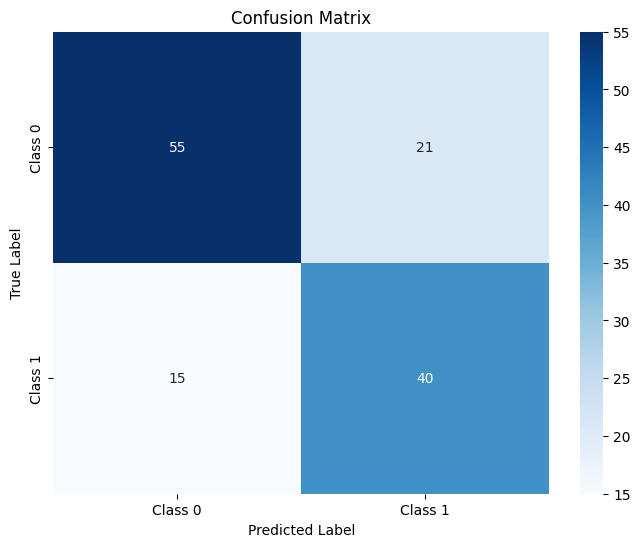

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the confusion matrix values
cm = np.array([[55, 21],  # [True Negative, False Positive]
               [15, 40]])  # [False Negative, True Positive]

# Define class labels
class_names = ['Class 0', 'Class 1']

# Create a heatmap using seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Updated VoxCNN

Epoch 0/19
----------
train Loss: 0.5979 Acc: 0.6567 AUC: 0.5461
valid Loss: 0.5679 Acc: 0.6565 AUC: 0.5718

Epoch 1/19
----------
train Loss: 0.5510 Acc: 0.6904 AUC: 0.6743
valid Loss: 0.5688 Acc: 0.6870 AUC: 0.6814

Epoch 2/19
----------
train Loss: 0.5279 Acc: 0.7092 AUC: 0.6906
valid Loss: 0.5417 Acc: 0.6794 AUC: 0.7075

Epoch 3/19
----------
train Loss: 0.5057 Acc: 0.7355 AUC: 0.7348
valid Loss: 0.5409 Acc: 0.6718 AUC: 0.7093

Epoch 4/19
----------
train Loss: 0.4821 Acc: 0.7486 AUC: 0.7858
valid Loss: 0.5320 Acc: 0.7023 AUC: 0.7233

Epoch 5/19
----------
train Loss: 0.4591 Acc: 0.7430 AUC: 0.8063
valid Loss: 0.5094 Acc: 0.6794 AUC: 0.7261

Epoch 6/19
----------
train Loss: 0.4451 Acc: 0.7824 AUC: 0.8436
valid Loss: 0.5108 Acc: 0.6718 AUC: 0.7212

Epoch 7/19
----------
train Loss: 0.4408 Acc: 0.7486 AUC: 0.8299
valid Loss: 0.5024 Acc: 0.6641 AUC: 0.7318

Epoch 8/19
----------
train Loss: 0.4260 Acc: 0.7692 AUC: 0.8508
valid Loss: 0.5041 Acc: 0.6718 AUC: 0.7372

Epoch 9/19
--------

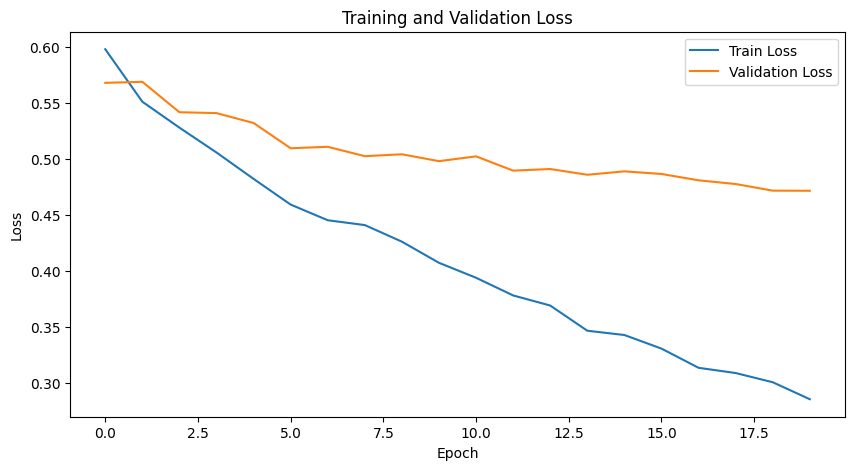

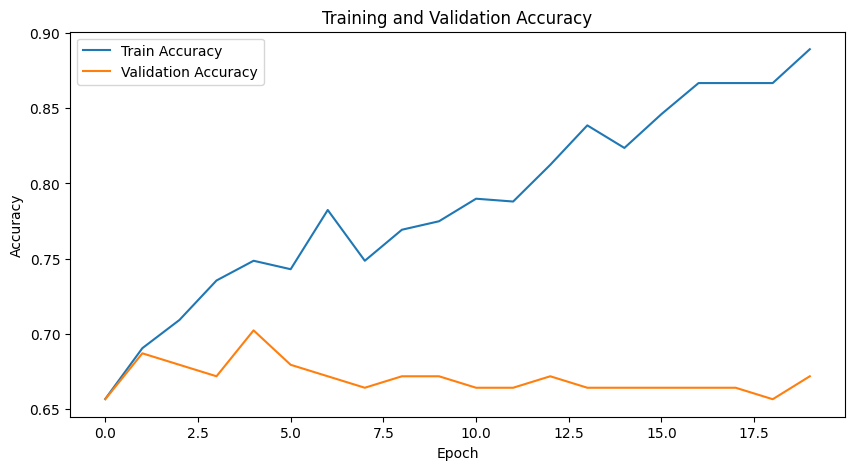

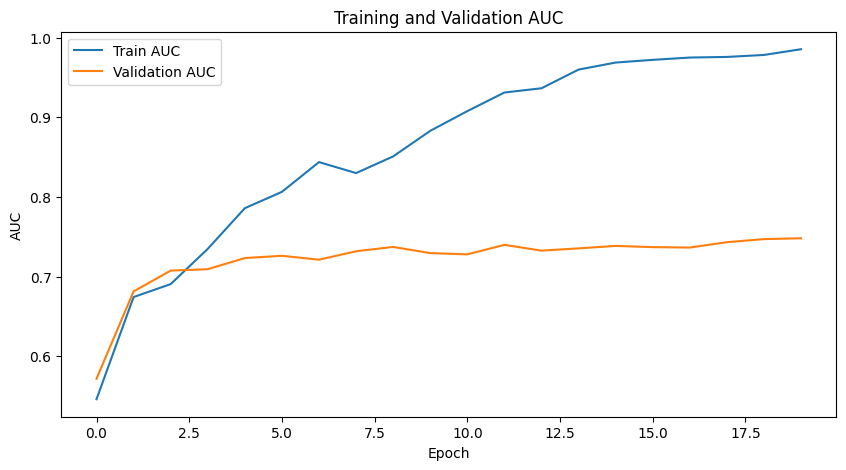

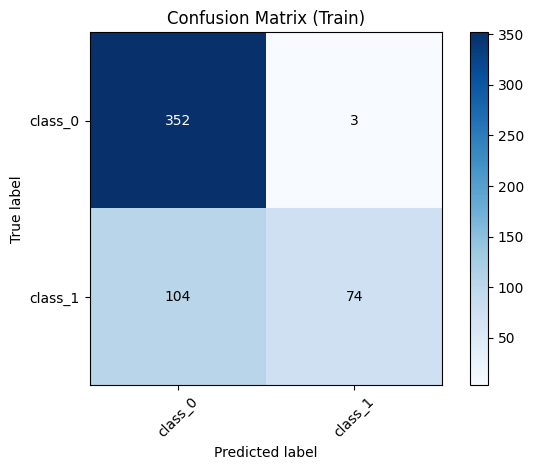

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import copy
import time

# Define the model class
class VoxCNN(nn.Module):
    def __init__(self, num_classes):
        super(VoxCNN, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(),
            nn.Conv3d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )

        self.conv_layer3 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )

        self.conv_layer4 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )

        self.class_layer = nn.Sequential(
            nn.Linear(5120, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),  # Updated: Lower dropout rate
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = x.view(x.size(0), -1)
        x = self.class_layer(x)
        return x

# Adjusted class weights
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight = torch.from_numpy(weight)
class_weight = class_weight.max() / class_weight
class_weight = class_weight / class_weight.max()
class_weight = class_weight.type(torch.FloatTensor)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datasets = {'train': train_dataset, 'valid': valid_dataset}
dataloaders = {'train': train_loader, 'valid': valid_loader}

# Define the model
model = VoxCNN(2).to(device)

# Define the optimizer with an increased learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.001)

# Use ReduceLROnPlateau scheduler to reduce the learning rate based on validation loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Apply class weights to the loss function
criterion = nn.CrossEntropyLoss(weight=class_weight.to(device))

num_epochs = 20

# Define functions for training and plotting confusion matrix
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accuracies = []
    train_aucs = []
    val_losses = []
    val_accuracies = []
    val_aucs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            all_labels = []
            all_preds = []
            all_probs = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.type(torch.LongTensor).to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(outputs[:, 1].detach().cpu().numpy())

            if phase == 'valid':
                scheduler.step(running_loss / len(datasets[phase]))

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            epoch_auc = roc_auc_score(all_labels, all_probs)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
                train_aucs.append(epoch_auc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                val_aucs.append(epoch_auc)

            print('{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_auc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation AUCs
    plt.figure(figsize=(10, 5))
    plt.plot(train_aucs, label='Train AUC')
    plt.plot(val_aucs, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.legend()
    plt.show()

    return model

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Train the model
trained_model = train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device)

# Get predictions for the entire dataset (training set only)
all_predictions = []
all_targets = []
all_probs = []

for inputs, labels in dataloaders['train']:  # Use the train loader for the entire dataset
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = trained_model(inputs)
    _, preds = torch.max(outputs, 1)
    all_predictions.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())
    all_probs.extend(outputs[:, 1].detach().cpu().numpy())

# Compute confusion matrix for the entire dataset
cm_train = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix for training set
plot_confusion_matrix(cm_train, classes=['class_0', 'class_1'], title='Confusion Matrix (Train)')

plt.show()


# VoxCNN with both confusion matrix

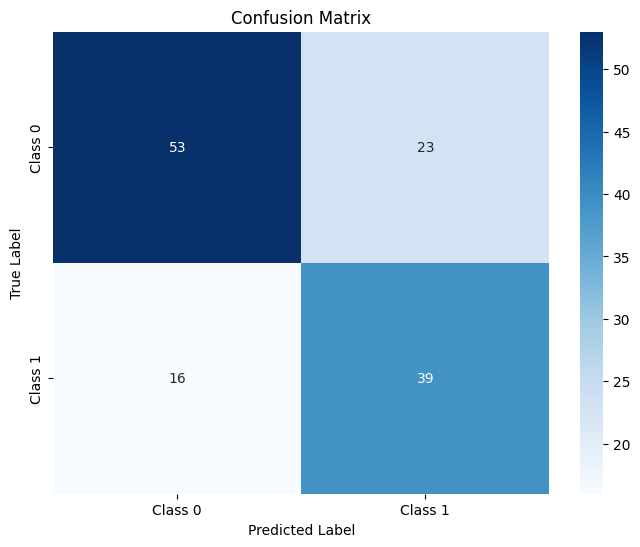

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the confusion matrix values
cm = np.array([[53, 23],  # [True Negatives, False Positives]
               [16, 39]])  # [False Negatives, True Positives]

# Define class labels
class_names = ['Class 0', 'Class 1']

# Create a heatmap using seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Benchmark Model

Epoch 0/19
----------
train Loss: 0.7485 Acc: 0.5497 AUC: 0.5903
valid Loss: 0.5028 Acc: 0.6718 AUC: 0.6682

Epoch 1/19
----------
train Loss: 0.6036 Acc: 0.6942 AUC: 0.7274
valid Loss: 0.4483 Acc: 0.6947 AUC: 0.6057

Epoch 2/19
----------
train Loss: 0.5148 Acc: 0.7711 AUC: 0.7990
valid Loss: 0.5147 Acc: 0.6794 AUC: 0.6987

Epoch 3/19
----------
train Loss: 0.4476 Acc: 0.8124 AUC: 0.8759
valid Loss: 0.5877 Acc: 0.6947 AUC: 0.6553

Epoch 4/19
----------
train Loss: 0.3725 Acc: 0.8799 AUC: 0.9341
valid Loss: 0.5334 Acc: 0.7252 AUC: 0.7367

Epoch 5/19
----------
train Loss: 0.3342 Acc: 0.8987 AUC: 0.9359
valid Loss: 0.5915 Acc: 0.6718 AUC: 0.7398

Epoch 6/19
----------
train Loss: 0.2844 Acc: 0.9343 AUC: 0.9581
valid Loss: 0.4539 Acc: 0.6870 AUC: 0.6984

Epoch 7/19
----------
train Loss: 0.2357 Acc: 0.9512 AUC: 0.9837
valid Loss: 0.4670 Acc: 0.7176 AUC: 0.7183

Epoch 8/19
----------
train Loss: 0.2243 Acc: 0.9418 AUC: 0.9864
valid Loss: 0.5065 Acc: 0.7176 AUC: 0.7478

Epoch 9/19
--------

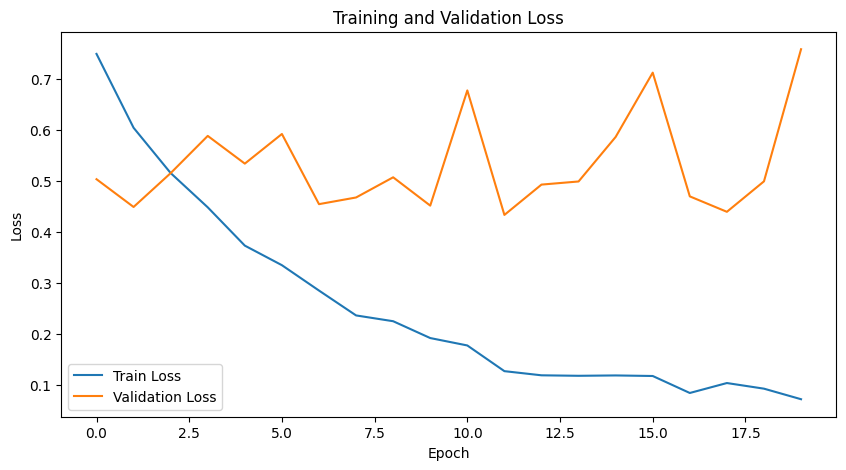

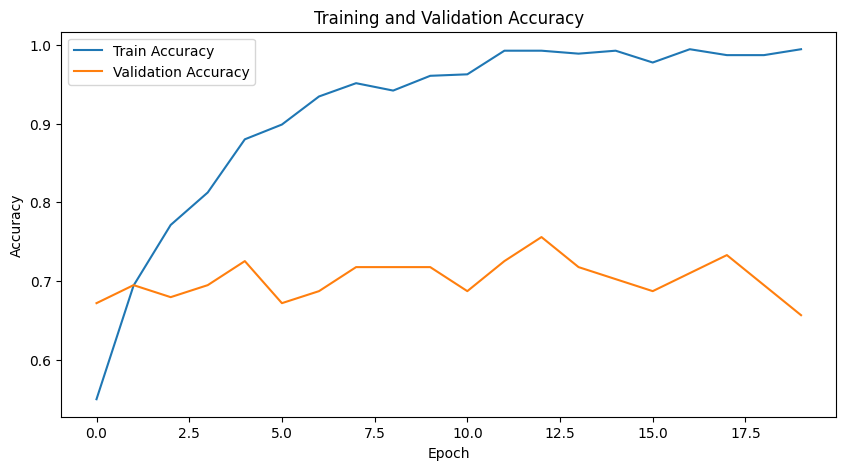

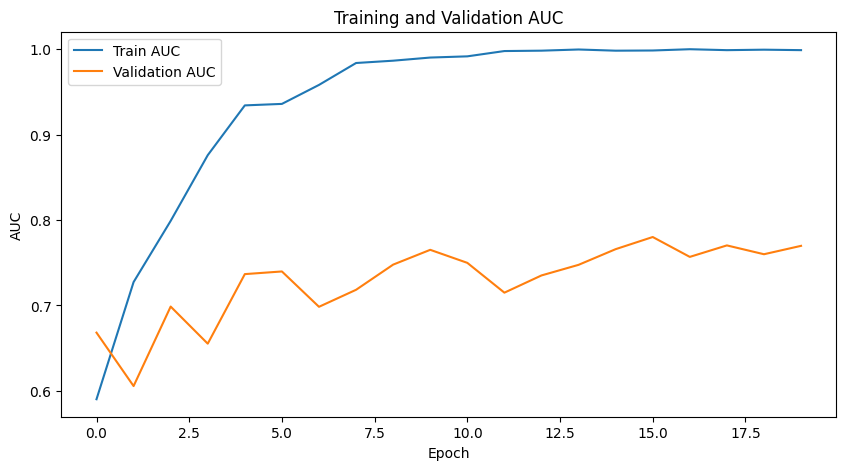

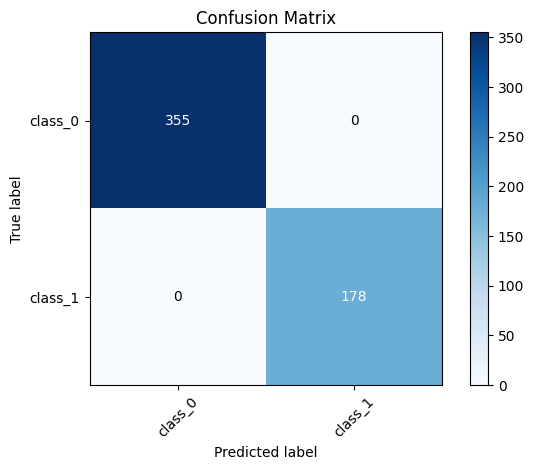

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import copy
import time

# Define the model class
class FEP_HC(nn.Module):
    def __init__(self, num_classes):
        super(FEP_HC, self).__init__()

        self.conv_layer1 = self._make_conv_layer(1, 32)
        self.conv_layer2 = self._make_conv_layer(32, 64)
        self.conv_layer3 = self._make_conv_layer(64, 128)
        self.conv_layer4 = self._make_conv_layer(128, 256)
        self.conv_layer5 = nn.Conv3d(256, 1024, kernel_size=(4, 4, 5), padding=0)  # Reduced from 2048 to 1024

        self.fc5 = nn.Linear(1024, 512)
        self.relu = nn.LeakyReLU()
        self.batch0 = nn.BatchNorm1d(512)
        self.drop = nn.Dropout(p=0.3)  # Increased dropout
        self.fc6 = nn.Linear(512, 256)
        self.relu = nn.LeakyReLU()
        self.batch1 = nn.BatchNorm1d(256)

        self.drop = nn.Dropout(p=0.3)
        self.fc7 = nn.Linear(256, num_classes)

    def _make_conv_layer(self, in_c, out_c):
        conv_layer = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_c),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )
        return conv_layer

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.batch0(x)
        x = self.drop(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.batch1(x)
        x = self.drop(x)
        x = self.fc7(x)
        return x

# Define other parameters
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight = torch.from_numpy(weight)
class_weight = class_weight.max() / class_weight
class_weight = class_weight / class_weight.max()
class_weight = class_weight.type(torch.FloatTensor)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datasets = {'train': train_dataset, 'valid': valid_dataset}
dataloaders = {'train': train_loader, 'valid': valid_loader}

# Define the model
model = FEP_HC(2)

# Define the optimizer with the desired parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.001)

# Adjust the scheduler to ReduceLROnPlateau for more dynamic learning rate adjustment
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Apply class weights to the loss function
criterion = nn.CrossEntropyLoss(weight=class_weight.to(device))

num_epochs = 20  # Increased number of epochs

# Define functions for training and plotting confusion matrix
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accuracies = []
    train_aucs = []
    val_losses = []
    val_accuracies = []
    val_aucs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            all_labels = []
            all_preds = []
            all_probs = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.type(torch.LongTensor).to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(outputs[:, 1].detach().cpu().numpy())

            if phase == 'train':
                scheduler.step(running_loss / len(datasets[phase]))  # Step scheduler based on the loss

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            epoch_auc = roc_auc_score(all_labels, all_probs)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
                train_aucs.append(epoch_auc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                val_aucs.append(epoch_auc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC: {epoch_auc:.4f}')

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_aucs, label='Train AUC')
    plt.plot(val_aucs, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.legend()
    plt.show()

    return model

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Train the model
trained_model = train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device)

# Get predictions for the entire dataset (including validation)
all_predictions = []
all_targets = []
for inputs, labels in dataloaders['train']:  # Use the train loader for the entire dataset
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = trained_model(inputs)
    _, preds = torch.max(outputs, 1)
    all_predictions.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())

# Compute confusion matrix for the entire dataset
cm = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix
plot_confusion_matrix(cm, classes=['class_0', 'class_1'], title='Confusion Matrix')

plt.show()


# Benchmark Model with Both confusion matrix

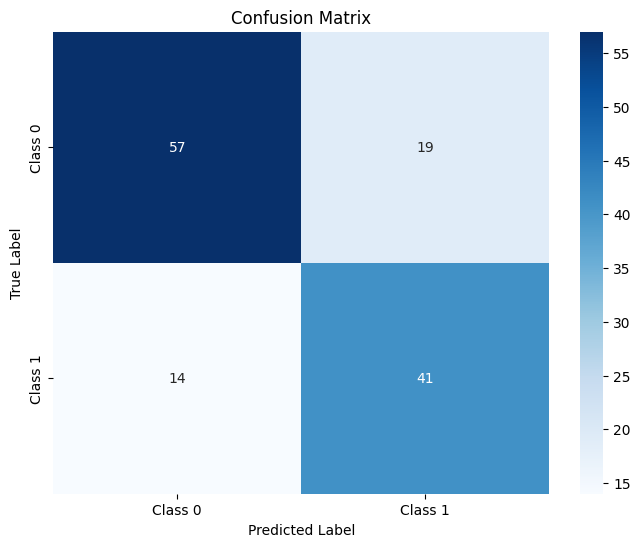

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the confusion matrix values
cm = np.array([[57, 19],  # [True Negatives, False Positives]
               [14, 41]])  # [False Negatives, True Positives]

# Define class labels
class_names = ['Class 0', 'Class 1']

# Create a heatmap using seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


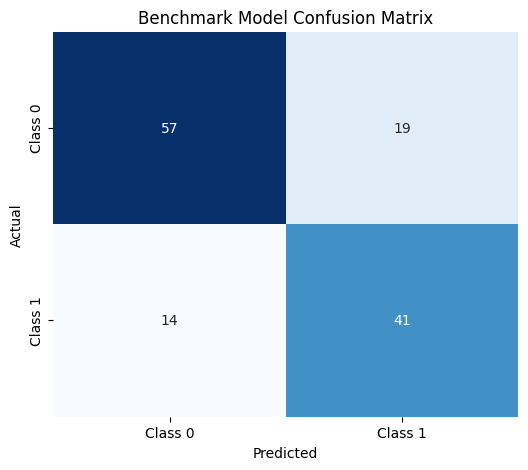

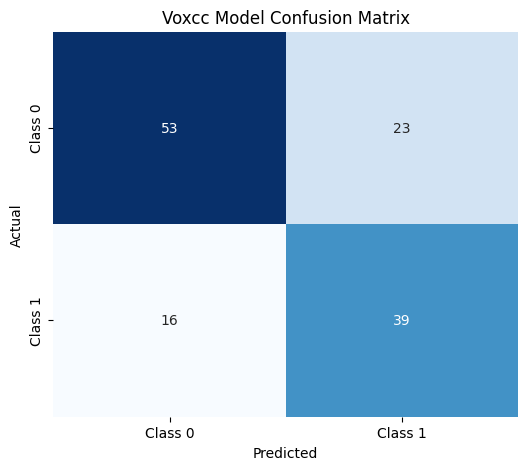

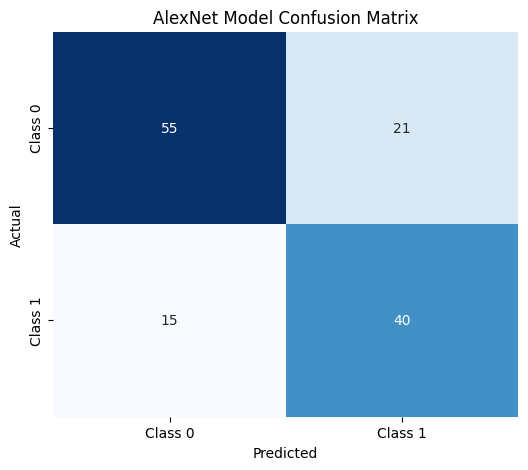

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title, labels=['Class 0', 'Class 1']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Confusion matrices for each model
cm_benchmark = np.array([[57, 19],
                         [14, 41]])

cm_voxcc = np.array([[53, 23],
                     [16, 39]])

cm_alexnet = np.array([[55, 21],
                       [15, 40]])

# Plot each confusion matrix
plot_confusion_matrix(cm_benchmark, 'Benchmark Model Confusion Matrix')
plot_confusion_matrix(cm_voxcc, 'Voxcc Model Confusion Matrix')
plot_confusion_matrix(cm_alexnet, 'AlexNet Model Confusion Matrix')


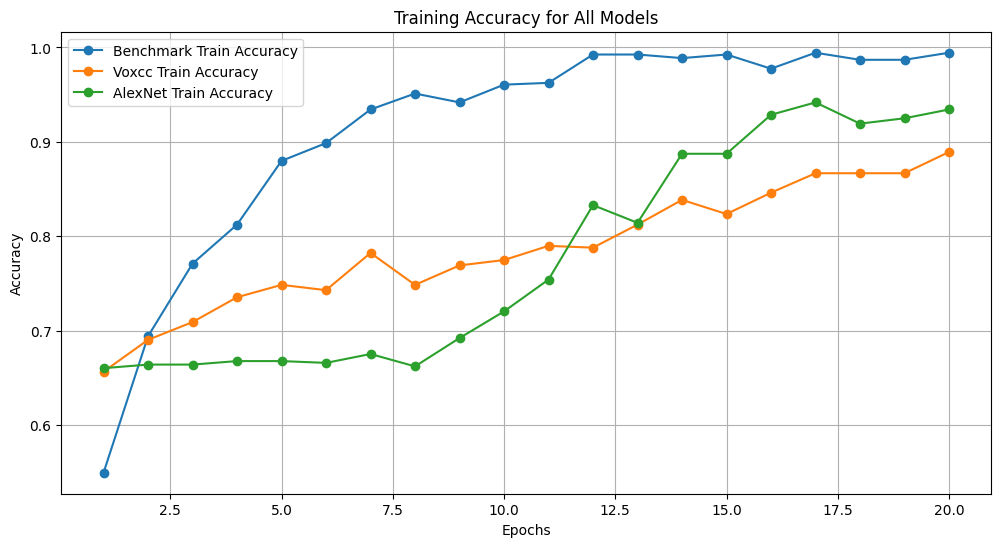

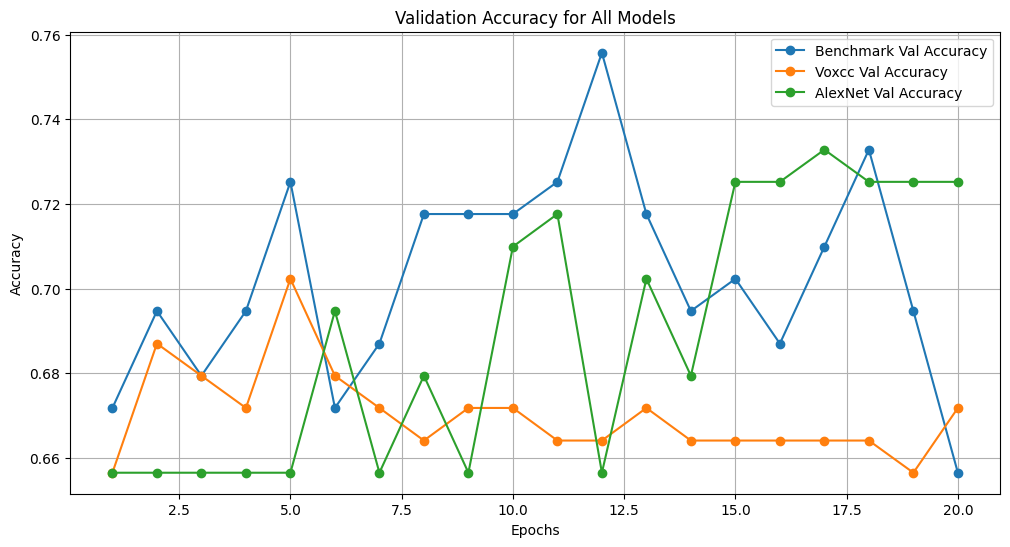

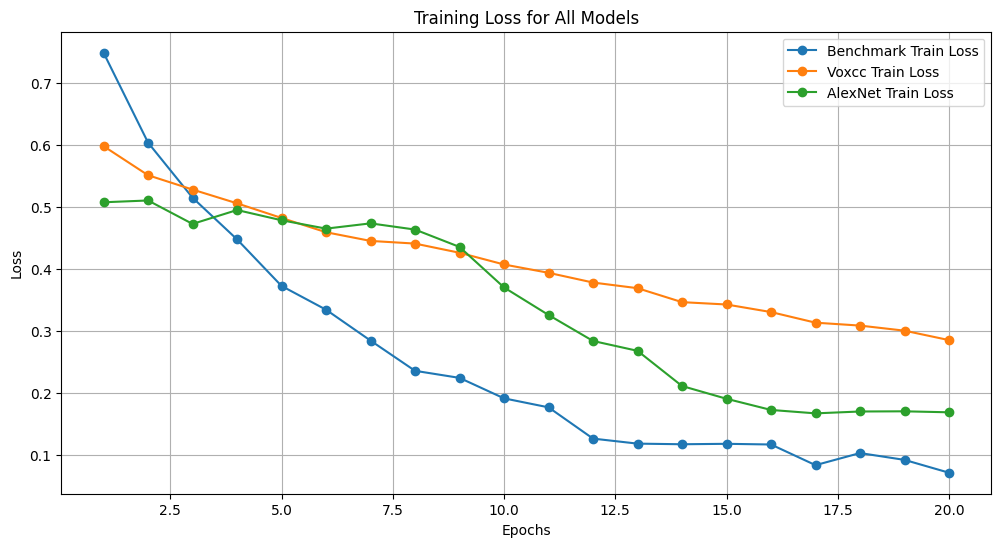

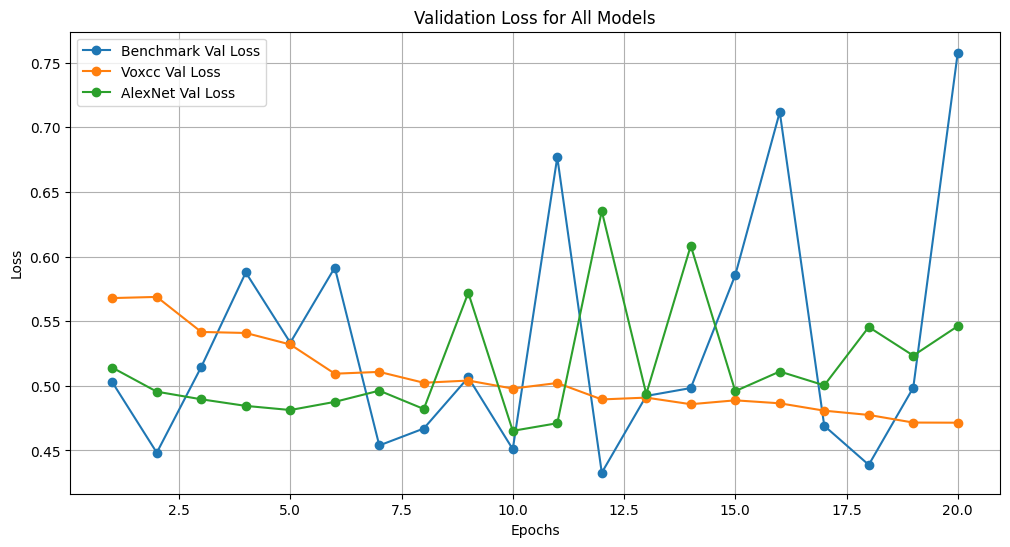

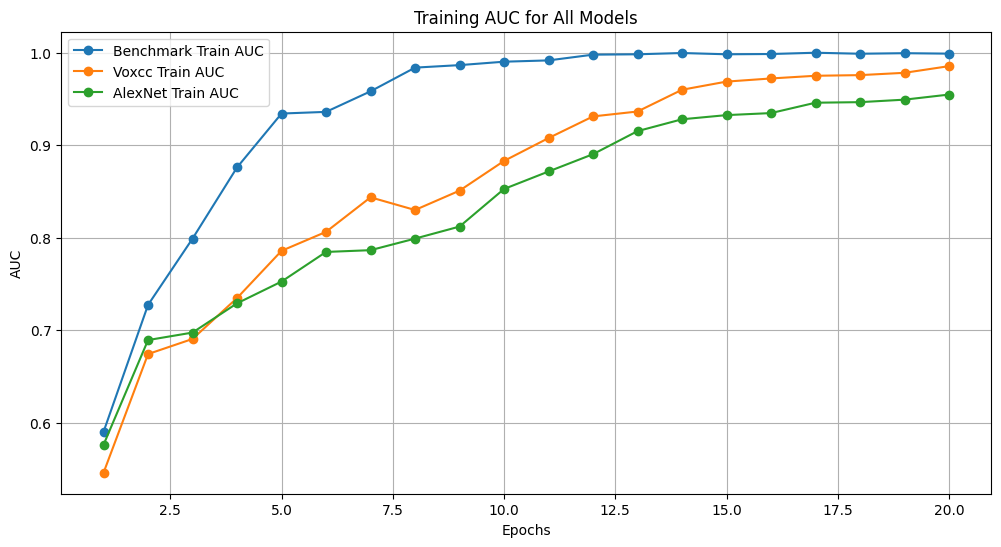

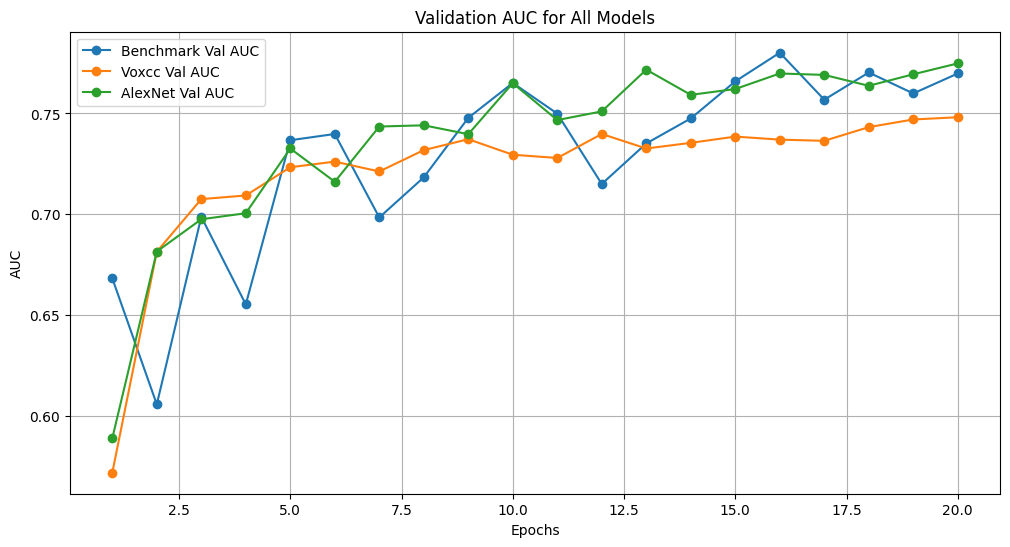

In [ ]:
import matplotlib.pyplot as plt

# Data for each model
epochs = list(range(1, 21))

# Benchmark Model
benchmark_train_acc = [0.5497, 0.6942, 0.7711, 0.8124, 0.8799, 0.8987, 0.9343, 0.9512, 0.9418, 0.9606, 0.9625, 0.9925, 0.9925, 0.9887, 0.9925, 0.9775, 0.9944, 0.9869, 0.9869, 0.9944]
benchmark_val_acc = [0.6718, 0.6947, 0.6794, 0.6947, 0.7252, 0.6718, 0.6870, 0.7176, 0.7176, 0.7176, 0.7252, 0.7557, 0.7176, 0.6947, 0.7023, 0.6870, 0.7099, 0.7328, 0.6947, 0.6565]
benchmark_train_loss = [0.7485, 0.6036, 0.5148, 0.4476, 0.3725, 0.3342, 0.2844, 0.2357, 0.2243, 0.1913, 0.1768, 0.1264, 0.1183, 0.1173, 0.1180, 0.1169, 0.0836, 0.1031, 0.0921, 0.0714]
benchmark_val_loss = [0.5028, 0.4483, 0.5147, 0.5877, 0.5334, 0.5915, 0.4539, 0.4670, 0.5065, 0.4510, 0.6769, 0.4328, 0.4922, 0.4983, 0.5857, 0.7118, 0.4691, 0.4389, 0.4986, 0.7577]
benchmark_train_auc = [0.5903, 0.7274, 0.7990, 0.8759, 0.9341, 0.9359, 0.9581, 0.9837, 0.9864, 0.9901, 0.9915, 0.9977, 0.9981, 0.9995, 0.9981, 0.9984, 0.9998, 0.9987, 0.9993, 0.9988]
benchmark_val_auc = [0.6682, 0.6057, 0.6987, 0.6553, 0.7367, 0.7398, 0.6984, 0.7183, 0.7478, 0.7651, 0.7499, 0.7150, 0.7351, 0.7475, 0.7659, 0.7801, 0.7568, 0.7703, 0.7599, 0.7698]

# Voxcc Model
voxcc_train_acc = [0.6567, 0.6904, 0.7092, 0.7355, 0.7486, 0.7430, 0.7824, 0.7486, 0.7692, 0.7749, 0.7899, 0.7880, 0.8124, 0.8386, 0.8236, 0.8462, 0.8668, 0.8668, 0.8668, 0.8893]
voxcc_val_acc = [0.6565, 0.6870, 0.6794, 0.6718, 0.7023, 0.6794, 0.6718, 0.6641, 0.6718, 0.6718, 0.6641, 0.6641, 0.6718, 0.6641, 0.6641, 0.6641, 0.6641, 0.6641, 0.6565, 0.6718]
voxcc_train_loss = [0.5979, 0.5510, 0.5279, 0.5057, 0.4821, 0.4591, 0.4451, 0.4408, 0.4260, 0.4071, 0.3937, 0.3780, 0.3689, 0.3464, 0.3426, 0.3304, 0.3133, 0.3086, 0.3004, 0.2852]
voxcc_val_loss = [0.5679, 0.5688, 0.5417, 0.5409, 0.5320, 0.5094, 0.5108, 0.5024, 0.5041, 0.4979, 0.5022, 0.4895, 0.4909, 0.4858, 0.4888, 0.4865, 0.4808, 0.4775, 0.4716, 0.4715]
voxcc_train_auc = [0.5461, 0.6743, 0.6906, 0.7348, 0.7858, 0.8063, 0.8436, 0.8299, 0.8508, 0.8829, 0.9076, 0.9310, 0.9363, 0.9598, 0.9686, 0.9720, 0.9749, 0.9756, 0.9781, 0.9853]
voxcc_val_auc = [0.5718, 0.6814, 0.7075, 0.7093, 0.7233, 0.7261, 0.7212, 0.7318, 0.7372, 0.7295, 0.7279, 0.7398, 0.7326, 0.7354, 0.7385, 0.7370, 0.7364, 0.7432, 0.7470, 0.7481]

# AlexNet Model
alexnet_train_acc = [0.6604, 0.6642, 0.6642, 0.6679, 0.6679, 0.6660, 0.6754, 0.6623, 0.6923, 0.7205, 0.7542, 0.8330, 0.8143, 0.8874, 0.8874, 0.9287, 0.9418, 0.9193, 0.9250, 0.9343]
alexnet_val_acc = [0.6565, 0.6565, 0.6565, 0.6565, 0.6565, 0.6947, 0.6565, 0.6794, 0.6565, 0.7099, 0.7176, 0.6565, 0.7023, 0.6794, 0.7252, 0.7252, 0.7328, 0.7252, 0.7252, 0.7252]
alexnet_train_loss = [0.5074, 0.5103, 0.4725, 0.4949, 0.4784, 0.4649, 0.4734, 0.4634, 0.4354, 0.3701, 0.3257, 0.2838, 0.2679, 0.2112, 0.1906, 0.1726, 0.1671, 0.1701, 0.1704, 0.1688]
alexnet_val_loss = [0.5141, 0.4955, 0.4896, 0.4845, 0.4813, 0.4876, 0.4963, 0.4821, 0.5720, 0.4652, 0.4711, 0.6352, 0.4937, 0.6084, 0.4959, 0.5111, 0.5004, 0.5455, 0.5234, 0.5462]
alexnet_train_auc = [0.5763, 0.6894, 0.6975, 0.7291, 0.7526, 0.7846, 0.7865, 0.7990, 0.8120, 0.8526, 0.8715, 0.8902, 0.9151, 0.9279, 0.9324, 0.9346, 0.9458, 0.9464, 0.9491, 0.9546]
alexnet_val_auc = [0.5889, 0.6815, 0.6975, 0.7005, 0.7326, 0.7161, 0.7435, 0.7441, 0.7397, 0.7650, 0.7467, 0.7510, 0.7717, 0.7592, 0.7621, 0.7698, 0.7691, 0.7637, 0.7694, 0.7748]

# Plotting Training Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, benchmark_train_acc, label='Benchmark Train Accuracy', marker='o')
plt.plot(epochs, voxcc_train_acc, label='Voxcc Train Accuracy', marker='o')
plt.plot(epochs, alexnet_train_acc, label='AlexNet Train Accuracy', marker='o')
plt.title('Training Accuracy for All Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, benchmark_val_acc, label='Benchmark Val Accuracy', marker='o')
plt.plot(epochs, voxcc_val_acc, label='Voxcc Val Accuracy', marker='o')
plt.plot(epochs, alexnet_val_acc, label='AlexNet Val Accuracy', marker='o')
plt.title('Validation Accuracy for All Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, benchmark_train_loss, label='Benchmark Train Loss', marker='o')
plt.plot(epochs, voxcc_train_loss, label='Voxcc Train Loss', marker='o')
plt.plot(epochs, alexnet_train_loss, label='AlexNet Train Loss', marker='o')
plt.title('Training Loss for All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, benchmark_val_loss, label='Benchmark Val Loss', marker='o')
plt.plot(epochs, voxcc_val_loss, label='Voxcc Val Loss', marker='o')
plt.plot(epochs, alexnet_val_loss, label='AlexNet Val Loss', marker='o')
plt.title('Validation Loss for All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training AUC
plt.figure(figsize=(12, 6))
plt.plot(epochs, benchmark_train_auc, label='Benchmark Train AUC', marker='o')
plt.plot(epochs, voxcc_train_auc, label='Voxcc Train AUC', marker='o')
plt.plot(epochs, alexnet_train_auc, label='AlexNet Train AUC', marker='o')
plt.title('Training AUC for All Models')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Validation AUC
plt.figure(figsize=(12, 6))
plt.plot(epochs, benchmark_val_auc, label='Benchmark Val AUC', marker='o')
plt.plot(epochs, voxcc_val_auc, label='Voxcc Val AUC', marker='o')
plt.plot(epochs, alexnet_val_auc, label='AlexNet Val AUC', marker='o')
plt.title('Validation AUC for All Models')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()


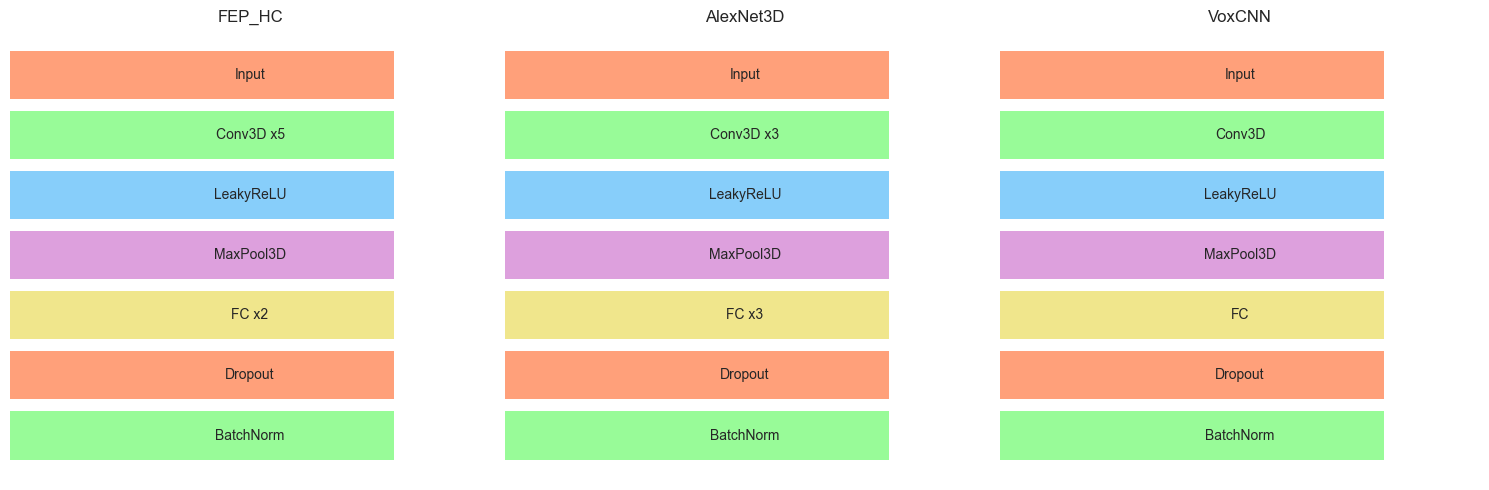

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def create_model_diagram(ax, layers, title):
    colors = ['#FFA07A', '#98FB98', '#87CEFA', '#DDA0DD', '#F0E68C']
    y_positions = np.arange(len(layers))
    ax.barh(y_positions, [0.8] * len(layers), align='center', color=colors[:len(layers)])
    ax.set_yticks(y_positions)
    ax.set_yticklabels(layers)
    ax.invert_yaxis()
    ax.set_xlabel('Layers')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.axis('off')
    for i, v in enumerate(layers):
        ax.text(0.5, i, v, ha='center', va='center')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

fep_hc_layers = ['Input', 'Conv3D x5', 'LeakyReLU', 'MaxPool3D', 'FC x2', 'Dropout', 'BatchNorm']
alexnet3d_layers = ['Input', 'Conv3D x3', 'LeakyReLU', 'MaxPool3D', 'FC x3', 'Dropout', 'BatchNorm']
voxcnn_layers = ['Input', 'Conv3D', 'LeakyReLU', 'MaxPool3D', 'FC', 'Dropout', 'BatchNorm']

create_model_diagram(ax1, fep_hc_layers, 'FEP_HC')
create_model_diagram(ax2, alexnet3d_layers, 'AlexNet3D')
create_model_diagram(ax3, voxcnn_layers, 'VoxCNN')

plt.tight_layout()
plt.savefig('cnn_architectures.png', dpi=300, bbox_inches='tight')
plt.show()

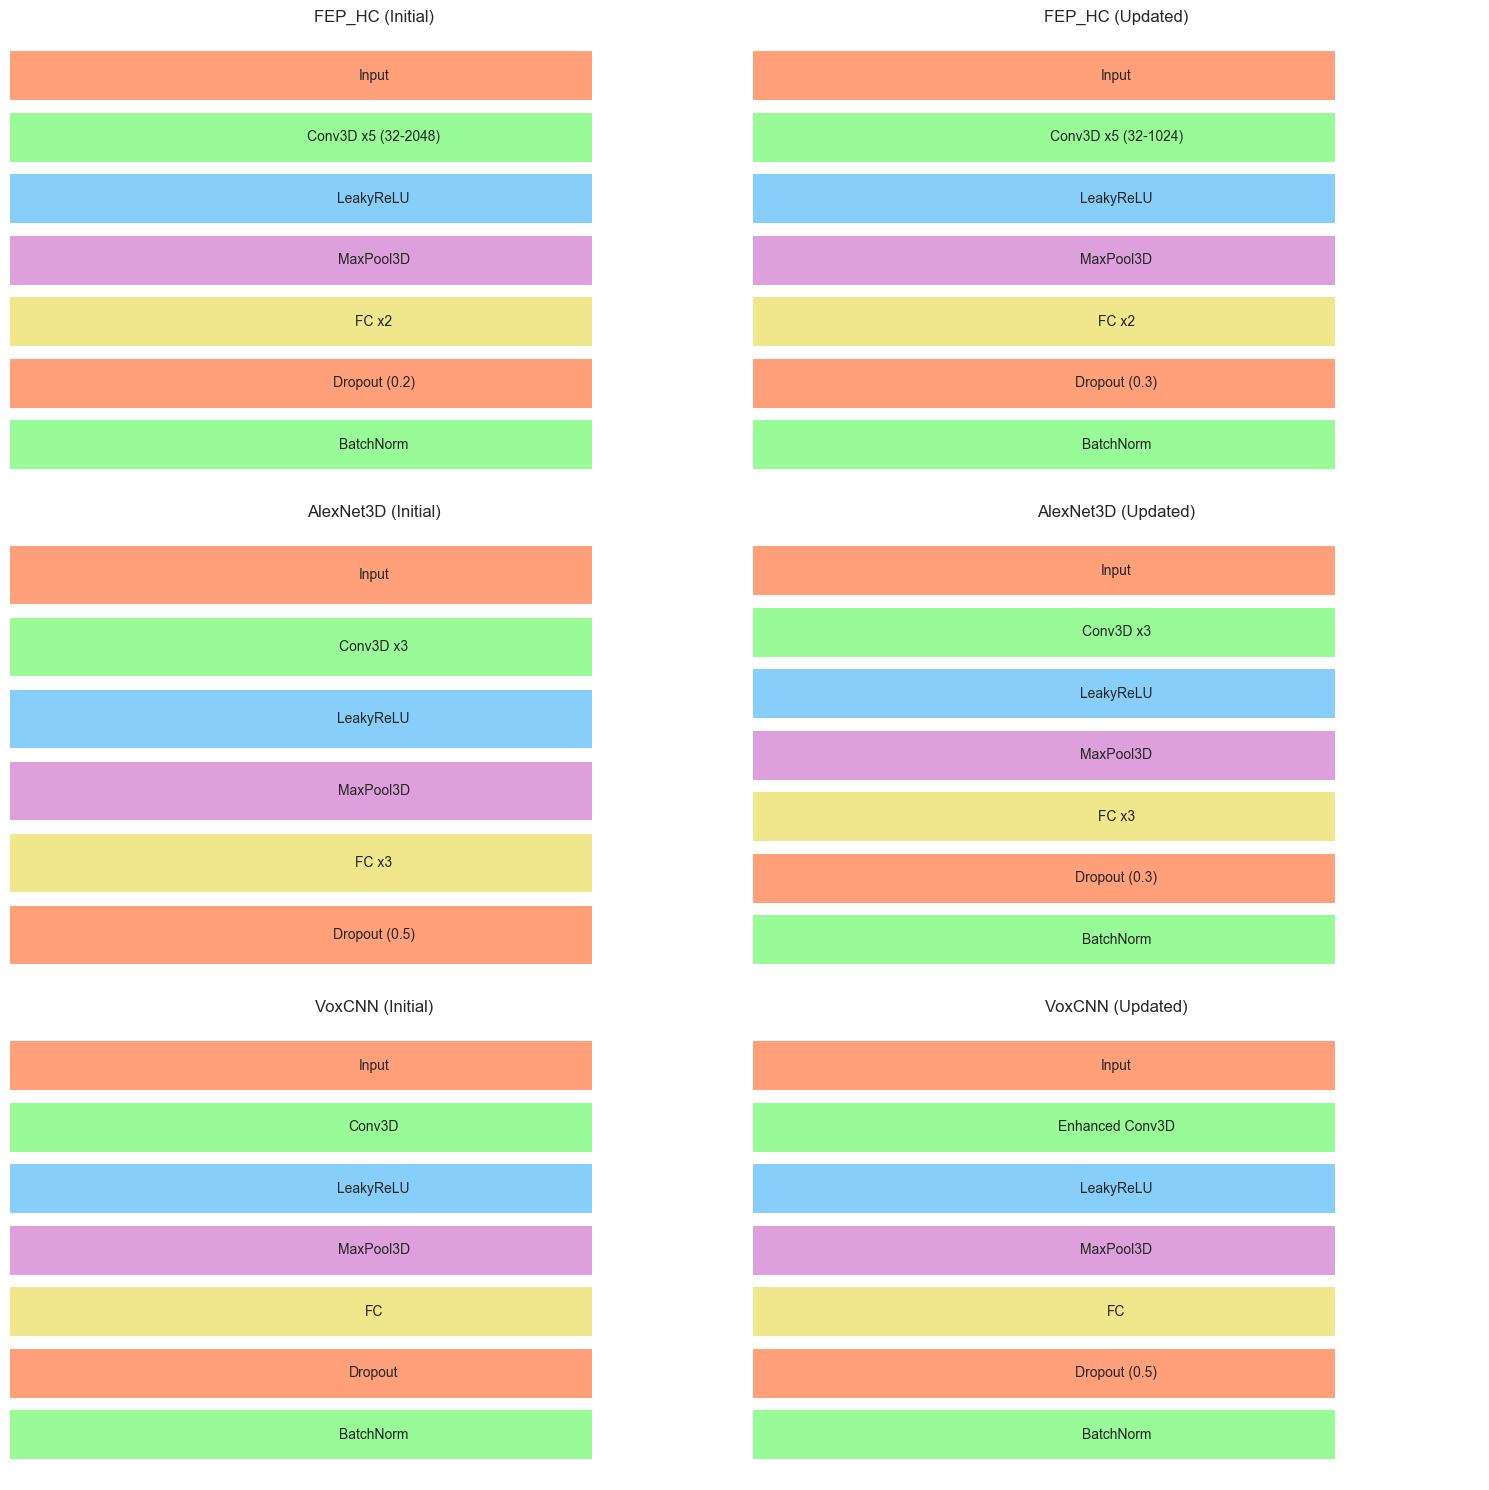

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def create_model_diagram(ax, layers, title):
    colors = ['#FFA07A', '#98FB98', '#87CEFA', '#DDA0DD', '#F0E68C']
    y_positions = np.arange(len(layers))
    ax.barh(y_positions, [0.8] * len(layers), align='center', color=colors[:len(layers)])
    ax.set_yticks(y_positions)
    ax.set_yticklabels(layers)
    ax.invert_yaxis()
    ax.set_xlabel('Layers')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.axis('off')
    for i, v in enumerate(layers):
        ax.text(0.5, i, v, ha='center', va='center')

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# FEP_HC
fep_hc_initial = ['Input', 'Conv3D x5 (32-2048)', 'LeakyReLU', 'MaxPool3D', 'FC x2', 'Dropout (0.2)', 'BatchNorm']
fep_hc_updated = ['Input', 'Conv3D x5 (32-1024)', 'LeakyReLU', 'MaxPool3D', 'FC x2', 'Dropout (0.3)', 'BatchNorm']

# AlexNet3D
alexnet3d_initial = ['Input', 'Conv3D x3', 'LeakyReLU', 'MaxPool3D', 'FC x3', 'Dropout (0.5)']
alexnet3d_updated = ['Input', 'Conv3D x3', 'LeakyReLU', 'MaxPool3D', 'FC x3', 'Dropout (0.3)', 'BatchNorm']

# VoxCNN
voxcnn_initial = ['Input', 'Conv3D', 'LeakyReLU', 'MaxPool3D', 'FC', 'Dropout', 'BatchNorm']
voxcnn_updated = ['Input', 'Enhanced Conv3D', 'LeakyReLU', 'MaxPool3D', 'FC', 'Dropout (0.5)', 'BatchNorm']

create_model_diagram(axs[0, 0], fep_hc_initial, 'FEP_HC (Initial)')
create_model_diagram(axs[0, 1], fep_hc_updated, 'FEP_HC (Updated)')
create_model_diagram(axs[1, 0], alexnet3d_initial, 'AlexNet3D (Initial)')
create_model_diagram(axs[1, 1], alexnet3d_updated, 'AlexNet3D (Updated)')
create_model_diagram(axs[2, 0], voxcnn_initial, 'VoxCNN (Initial)')
create_model_diagram(axs[2, 1], voxcnn_updated, 'VoxCNN (Updated)')

plt.tight_layout()
plt.savefig('cnn_architectures_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

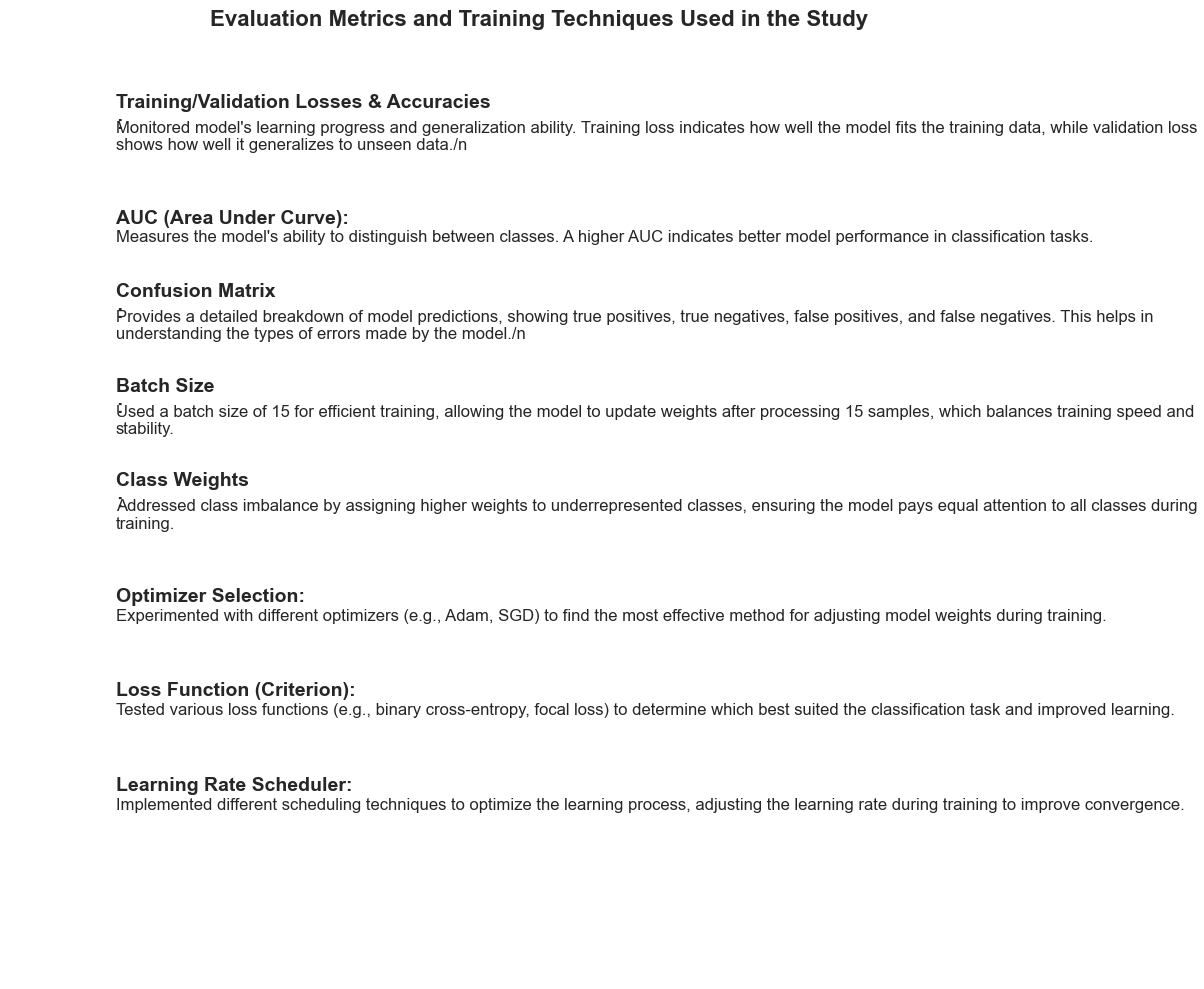

In [ ]:
import matplotlib.pyplot as plt

# Define the content for each metric and technique
metrics_and_techniques = {
    "Training/Validation Losses & Accuracies\n":
        "Monitored model's learning progress and generalization ability. Training loss indicates how well the model fits the training data, while validation loss shows how well it generalizes to unseen data./n",

    "AUC (Area Under Curve)":
        "Measures the model's ability to distinguish between classes. A higher AUC indicates better model performance in classification tasks.",

    "Confusion Matrix\n":
        "Provides a detailed breakdown of model predictions, showing true positives, true negatives, false positives, and false negatives. This helps in understanding the types of errors made by the model./n",

    "Batch Size\n":
        "Used a batch size of 15 for efficient training, allowing the model to update weights after processing 15 samples, which balances training speed and stability.",

    "Class Weights\n":
        "Addressed class imbalance by assigning higher weights to underrepresented classes, ensuring the model pays equal attention to all classes during training.",

    "Optimizer Selection":
        "Experimented with different optimizers (e.g., Adam, SGD) to find the most effective method for adjusting model weights during training.",

    "Loss Function (Criterion)":
        "Tested various loss functions (e.g., binary cross-entropy, focal loss) to determine which best suited the classification task and improved learning.",

    "Learning Rate Scheduler":
        "Implemented different scheduling techniques to optimize the learning process, adjusting the learning rate during training to improve convergence."
}

# Create the figure
plt.figure(figsize=(12, 10))
plt.title("Evaluation Metrics and Training Techniques Used in the Study", fontsize=16, fontweight='bold')

# Plot each metric and technique
for i, (key, value) in enumerate(metrics_and_techniques.items()):
    plt.text(0.1, 0.9 - i * 0.1, f"{key}:", fontsize=14, fontweight='bold')
    plt.text(0.1, 0.88 - i * 0.1, f"{value}", fontsize=12, wrap=True)

# Adjust layout
plt.axis('off')
plt.tight_layout()

# Save the infographic
plt.savefig('evaluation_metrics_and_techniques_simple.png', bbox_inches='tight')
plt.show()

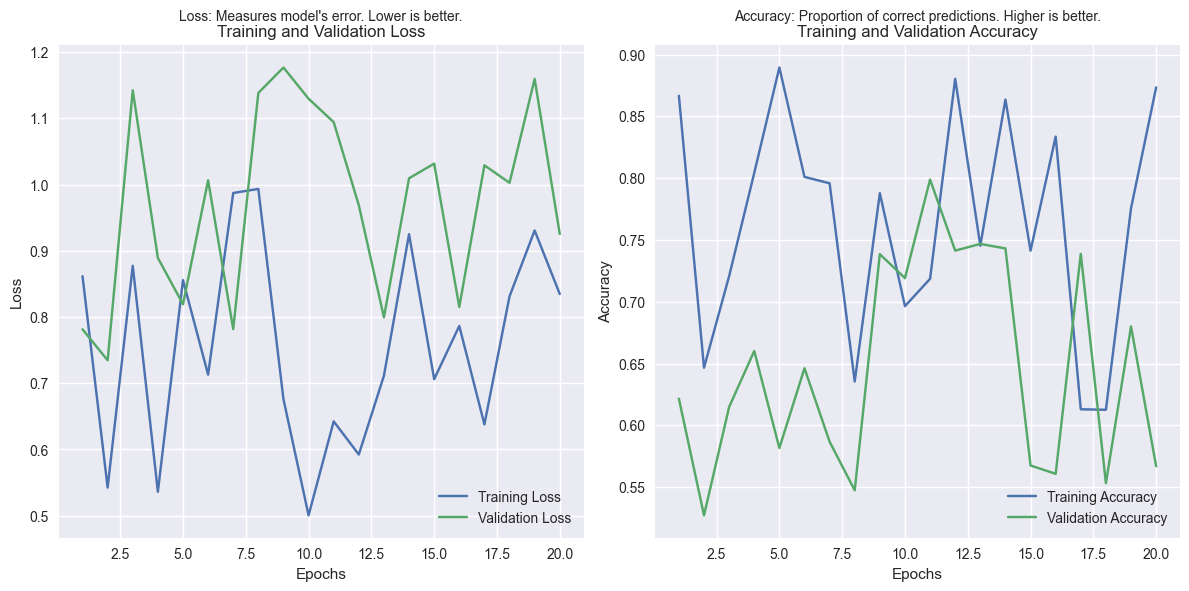

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data
epochs = range(1, 21)
train_loss = np.random.rand(20) * 0.5 + 0.5
val_loss = np.random.rand(20) * 0.5 + 0.7
train_acc = np.random.rand(20) * 0.3 + 0.6
val_acc = np.random.rand(20) * 0.3 + 0.5

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.text(0.5, 1.05, "Loss: Measures model's error. Lower is better.", transform=plt.gca().transAxes, fontsize=10, ha='center')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.text(0.5, 1.05, "Accuracy: Proportion of correct predictions. Higher is better.", transform=plt.gca().transAxes, fontsize=10, ha='center')

plt.tight_layout()
plt.savefig('loss_accuracy_explanation.png')
plt.show()

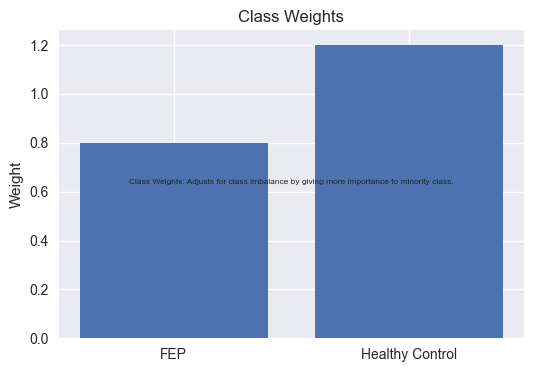

In [ ]:
class_weights = {'FEP': 0.8, 'Healthy Control': 1.2}
plt.figure(figsize=(6, 4))
plt.bar(class_weights.keys(), class_weights.values())
plt.title('Class Weights')
plt.ylabel('Weight')
plt.text(0.5, 0.5, "Class Weights: Adjusts for class imbalance by giving more importance to minority class.", transform=plt.gca().transAxes, fontsize=6, ha='center')
plt.savefig('class_weights_explanation.png')
plt.show()

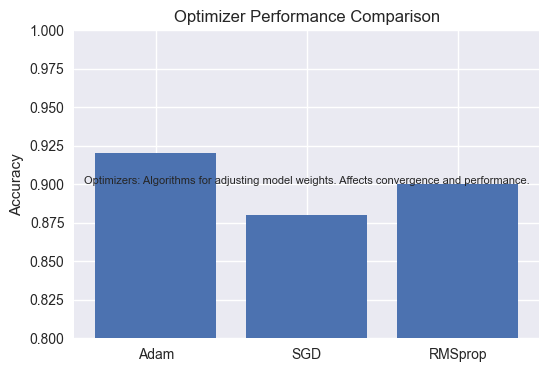

In [ ]:
optimizers = ['Adam', 'SGD', 'RMSprop']
performances = [0.92, 0.88, 0.90]
plt.figure(figsize=(6, 4))
plt.bar(optimizers, performances)
plt.title('Optimizer Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.text(0.5, 0.5, "Optimizers: Algorithms for adjusting model weights. Affects convergence and performance.", transform=plt.gca().transAxes, fontsize=8, ha='center')
plt.savefig('optimizer_explanation.png')
plt.show()

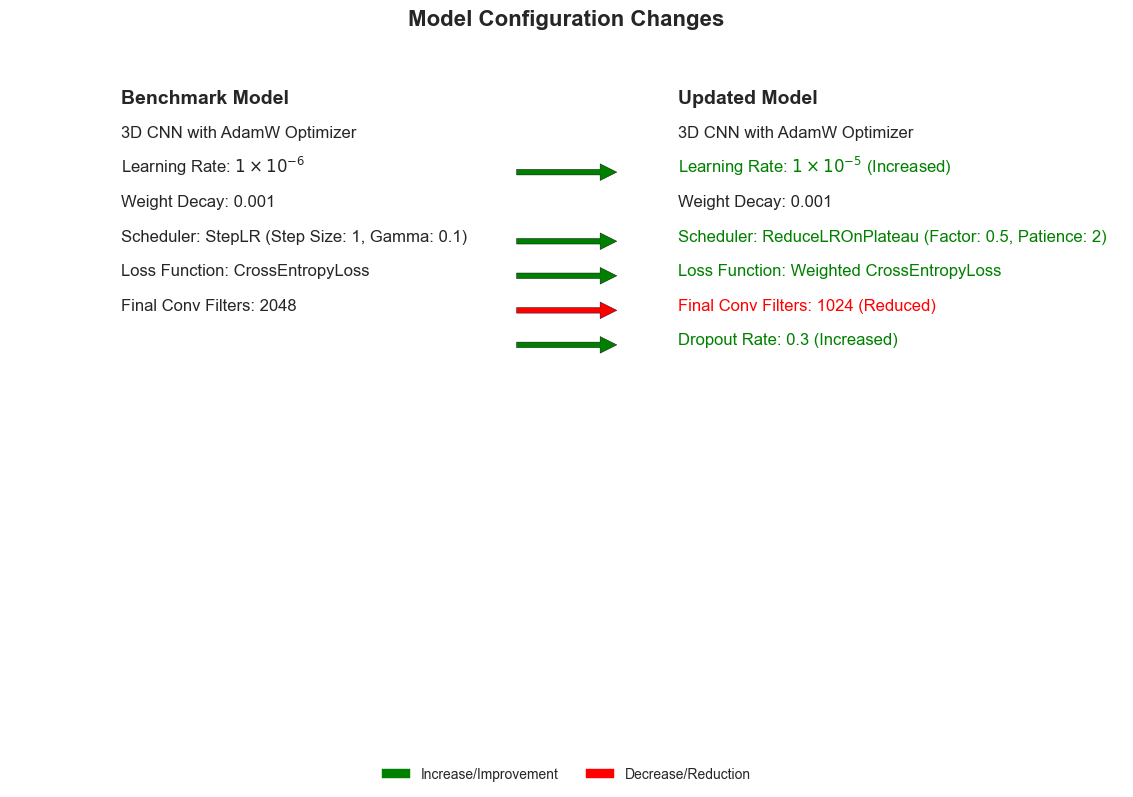

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Title
plt.title('Model Configuration Changes', fontsize=16, fontweight='bold')

# Benchmark Model
ax.text(0.1, 0.9, 'Benchmark Model', fontsize=14, fontweight='bold', ha='left')
ax.text(0.1, 0.85, '3D CNN with AdamW Optimizer', fontsize=12, ha='left')
ax.text(0.1, 0.8, 'Learning Rate: $1 \\times 10^{-6}$', fontsize=12, ha='left')
ax.text(0.1, 0.75, 'Weight Decay: 0.001', fontsize=12, ha='left')
ax.text(0.1, 0.7, 'Scheduler: StepLR (Step Size: 1, Gamma: 0.1)', fontsize=12, ha='left')
ax.text(0.1, 0.65, 'Loss Function: CrossEntropyLoss', fontsize=12, ha='left')
ax.text(0.1, 0.6, 'Final Conv Filters: 2048', fontsize=12, ha='left')

# Updated Model
ax.text(0.6, 0.9, 'Updated Model', fontsize=14, fontweight='bold', ha='left')
ax.text(0.6, 0.85, '3D CNN with AdamW Optimizer', fontsize=12, ha='left')
ax.text(0.6, 0.8, 'Learning Rate: $1 \\times 10^{-5}$ (Increased)', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.75, 'Weight Decay: 0.001', fontsize=12, ha='left')
ax.text(0.6, 0.7, 'Scheduler: ReduceLROnPlateau (Factor: 0.5, Patience: 2)', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.65, 'Loss Function: Weighted CrossEntropyLoss', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.6, 'Final Conv Filters: 1024 (Reduced)', fontsize=12, ha='left', color='red')
ax.text(0.6, 0.55, 'Dropout Rate: 0.3 (Increased)', fontsize=12, ha='left', color='green')

# Arrows and annotations to indicate changes
ax.annotate('', xy=(0.55, 0.8), xytext=(0.45, 0.8),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.7), xytext=(0.45, 0.7),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.65), xytext=(0.45, 0.65),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.6), xytext=(0.45, 0.6),
            arrowprops=dict(facecolor='red', shrink=0.05))
ax.annotate('', xy=(0.55, 0.55), xytext=(0.45, 0.55),
            arrowprops=dict(facecolor='green', shrink=0.05))

# Legend
green_patch = mpatches.Patch(color='green', label='Increase/Improvement')
red_patch = mpatches.Patch(color='red', label='Decrease/Reduction')
plt.legend(handles=[green_patch, red_patch], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
plt.savefig('model_configuration_changes.png', bbox_inches='tight')
plt.show()

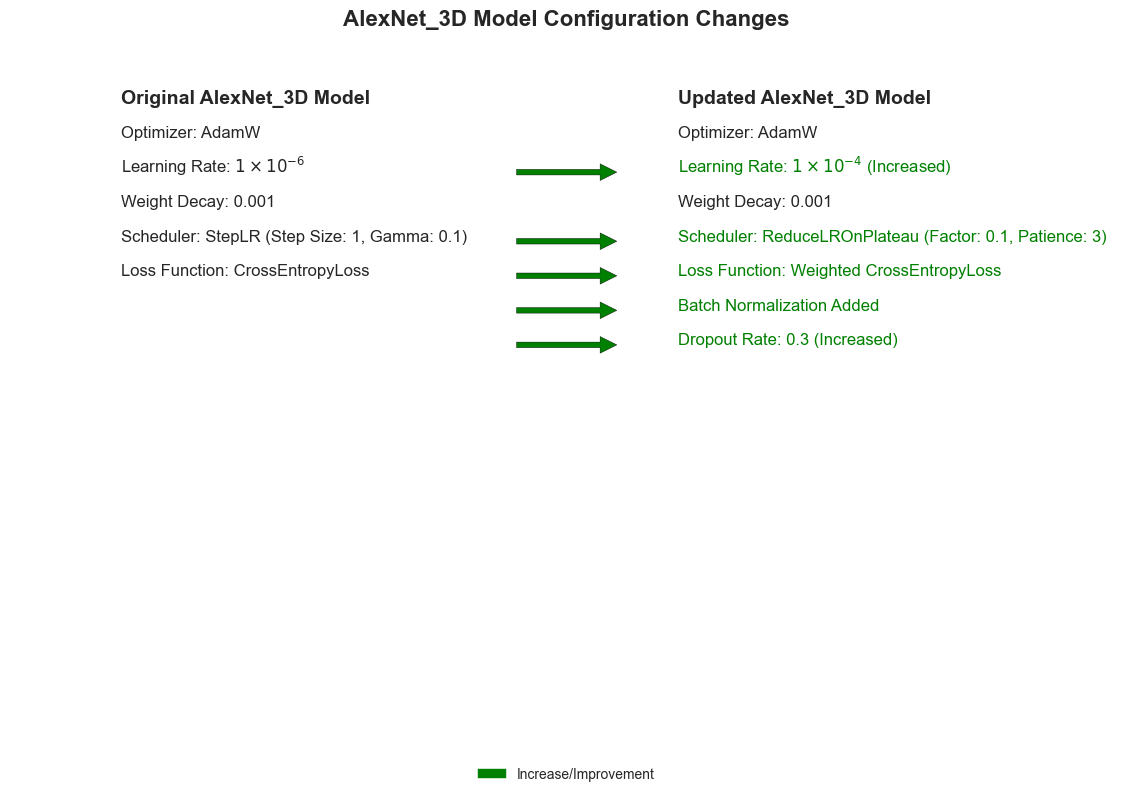

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Title
plt.title('AlexNet_3D Model Configuration Changes', fontsize=16, fontweight='bold')

# Original Model
ax.text(0.1, 0.9, 'Original AlexNet_3D Model', fontsize=14, fontweight='bold', ha='left')
ax.text(0.1, 0.85, 'Optimizer: AdamW', fontsize=12, ha='left')
ax.text(0.1, 0.8, 'Learning Rate: $1 \\times 10^{-6}$', fontsize=12, ha='left')
ax.text(0.1, 0.75, 'Weight Decay: 0.001', fontsize=12, ha='left')
ax.text(0.1, 0.7, 'Scheduler: StepLR (Step Size: 1, Gamma: 0.1)', fontsize=12, ha='left')
ax.text(0.1, 0.65, 'Loss Function: CrossEntropyLoss', fontsize=12, ha='left')

# Updated Model
ax.text(0.6, 0.9, 'Updated AlexNet_3D Model', fontsize=14, fontweight='bold', ha='left')
ax.text(0.6, 0.85, 'Optimizer: AdamW', fontsize=12, ha='left')
ax.text(0.6, 0.8, 'Learning Rate: $1 \\times 10^{-4}$ (Increased)', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.75, 'Weight Decay: 0.001', fontsize=12, ha='left')
ax.text(0.6, 0.7, 'Scheduler: ReduceLROnPlateau (Factor: 0.1, Patience: 3)', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.65, 'Loss Function: Weighted CrossEntropyLoss', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.6, 'Batch Normalization Added', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.55, 'Dropout Rate: 0.3 (Increased)', fontsize=12, ha='left', color='green')

# Arrows and annotations to indicate changes
ax.annotate('', xy=(0.55, 0.8), xytext=(0.45, 0.8),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.7), xytext=(0.45, 0.7),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.65), xytext=(0.45, 0.65),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.6), xytext=(0.45, 0.6),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.55), xytext=(0.45, 0.55),
            arrowprops=dict(facecolor='green', shrink=0.05))

# Legend
green_patch = mpatches.Patch(color='green', label='Increase/Improvement')
plt.legend(handles=[green_patch], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=1)

plt.tight_layout()
plt.savefig('alexnet3d_model_configuration_changes.png', bbox_inches='tight')
plt.show()

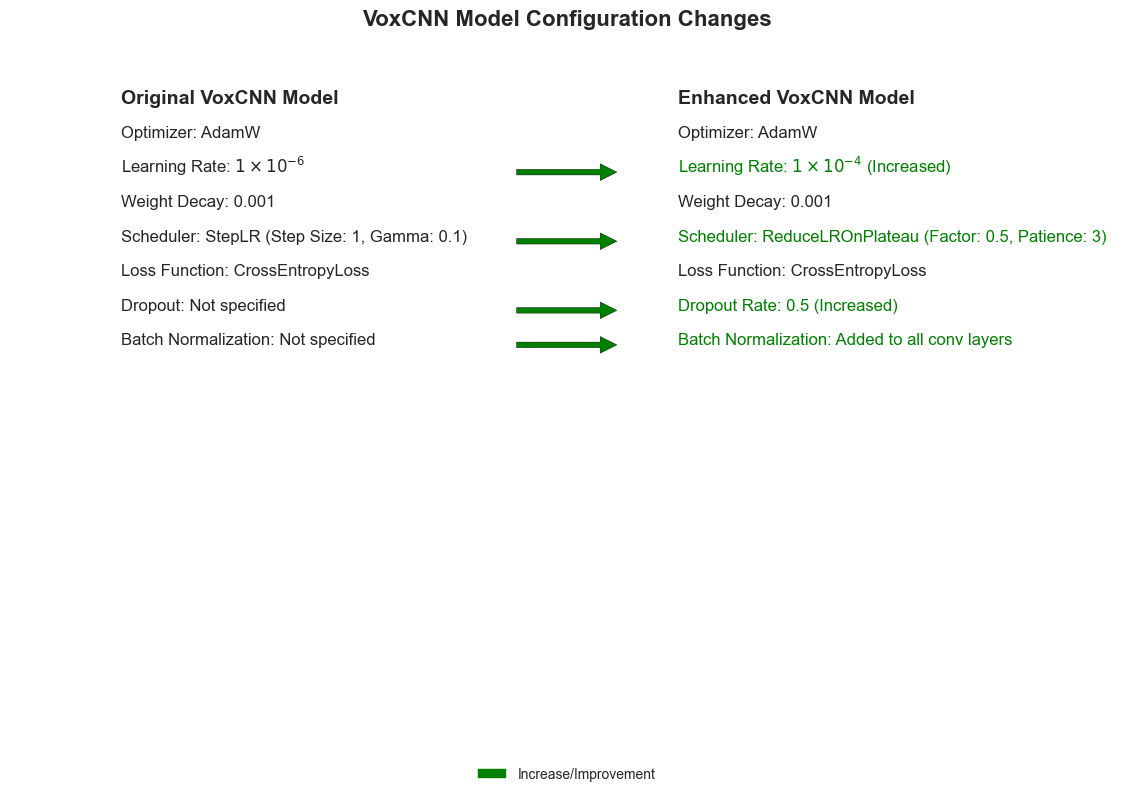

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Title
plt.title('VoxCNN Model Configuration Changes', fontsize=16, fontweight='bold')

# Original Model
ax.text(0.1, 0.9, 'Original VoxCNN Model', fontsize=14, fontweight='bold', ha='left')
ax.text(0.1, 0.85, 'Optimizer: AdamW', fontsize=12, ha='left')
ax.text(0.1, 0.8, 'Learning Rate: $1 \\times 10^{-6}$', fontsize=12, ha='left')
ax.text(0.1, 0.75, 'Weight Decay: 0.001', fontsize=12, ha='left')
ax.text(0.1, 0.7, 'Scheduler: StepLR (Step Size: 1, Gamma: 0.1)', fontsize=12, ha='left')
ax.text(0.1, 0.65, 'Loss Function: CrossEntropyLoss', fontsize=12, ha='left')
ax.text(0.1, 0.6, 'Dropout: Not specified', fontsize=12, ha='left')
ax.text(0.1, 0.55, 'Batch Normalization: Not specified', fontsize=12, ha='left')

# Updated Model
ax.text(0.6, 0.9, 'Enhanced VoxCNN Model', fontsize=14, fontweight='bold', ha='left')
ax.text(0.6, 0.85, 'Optimizer: AdamW', fontsize=12, ha='left')
ax.text(0.6, 0.8, 'Learning Rate: $1 \\times 10^{-4}$ (Increased)', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.75, 'Weight Decay: 0.001', fontsize=12, ha='left')
ax.text(0.6, 0.7, 'Scheduler: ReduceLROnPlateau (Factor: 0.5, Patience: 3)', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.65, 'Loss Function: CrossEntropyLoss', fontsize=12, ha='left')
ax.text(0.6, 0.6, 'Dropout Rate: 0.5 (Increased)', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.55, 'Batch Normalization: Added to all conv layers', fontsize=12, ha='left', color='green')

# Arrows and annotations to indicate changes
ax.annotate('', xy=(0.55, 0.8), xytext=(0.45, 0.8),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.7), xytext=(0.45, 0.7),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.6), xytext=(0.45, 0.6),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.55), xytext=(0.45, 0.55),
            arrowprops=dict(facecolor='green', shrink=0.05))

# Legend
green_patch = mpatches.Patch(color='green', label='Increase/Improvement')
plt.legend(handles=[green_patch], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=1)

plt.tight_layout()
plt.savefig('voxcnn_model_configuration_changes.png', bbox_inches='tight')
plt.show()

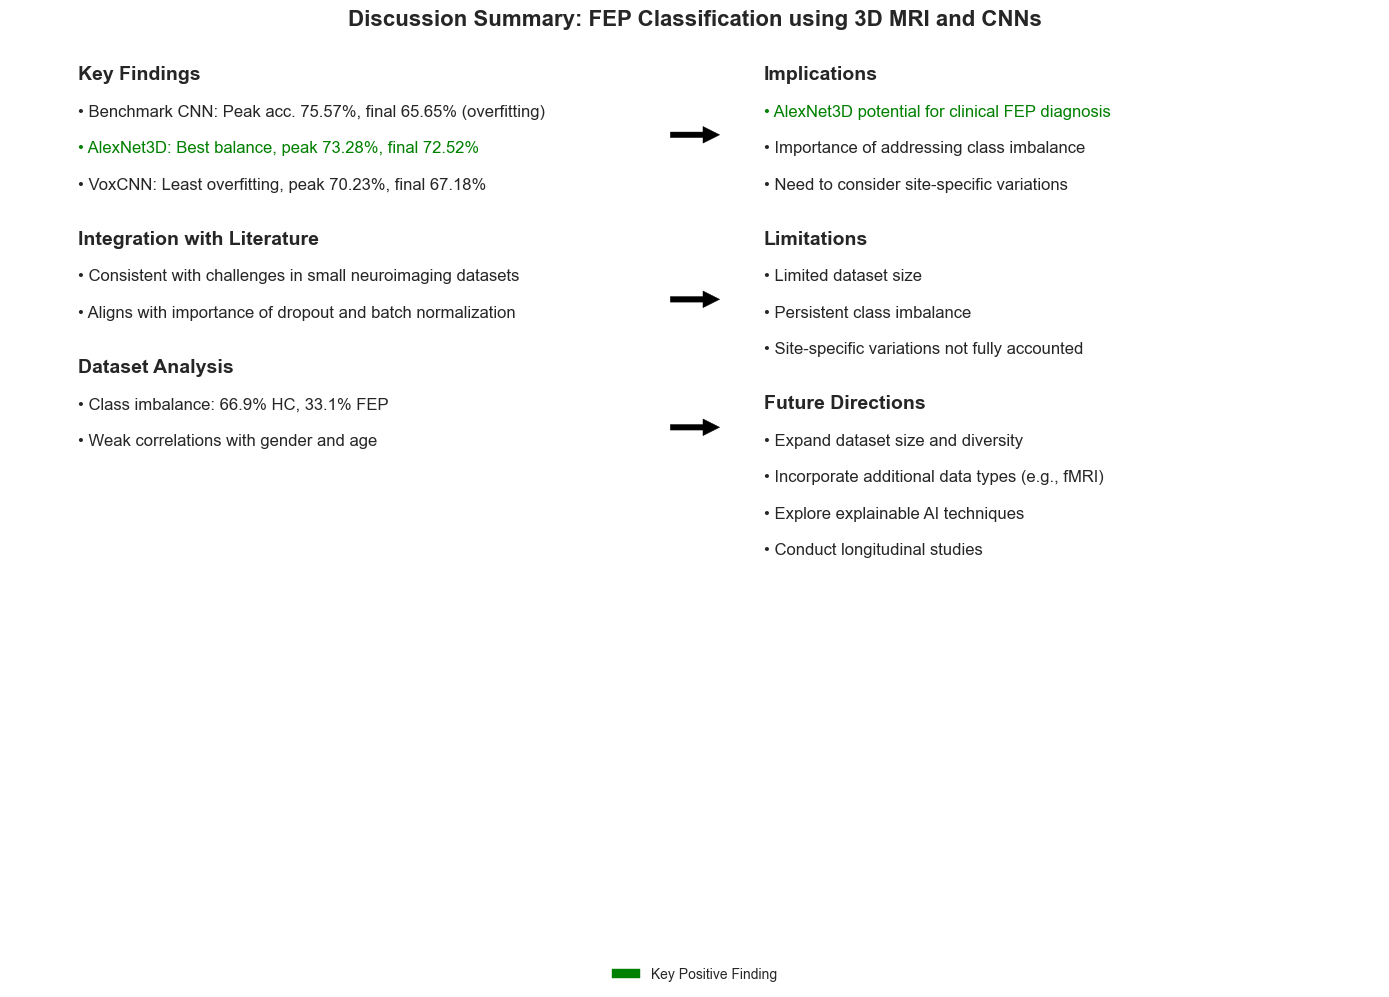

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Title
plt.title('Discussion Summary: FEP Classification using 3D MRI and CNNs', fontsize=16, fontweight='bold')

# Key Findings
ax.text(0.05, 0.95, 'Key Findings', fontsize=14, fontweight='bold', ha='left')
ax.text(0.05, 0.91, '• Benchmark CNN: Peak acc. 75.57%, final 65.65% (overfitting)', fontsize=12, ha='left')
ax.text(0.05, 0.87, '• AlexNet3D: Best balance, peak 73.28%, final 72.52%', fontsize=12, ha='left', color='green')
ax.text(0.05, 0.83, '• VoxCNN: Least overfitting, peak 70.23%, final 67.18%', fontsize=12, ha='left')

# Integration with Literature
ax.text(0.05, 0.77, 'Integration with Literature', fontsize=14, fontweight='bold', ha='left')
ax.text(0.05, 0.73, '• Consistent with challenges in small neuroimaging datasets', fontsize=12, ha='left')
ax.text(0.05, 0.69, '• Aligns with importance of dropout and batch normalization', fontsize=12, ha='left')

# Dataset Analysis
ax.text(0.05, 0.63, 'Dataset Analysis', fontsize=14, fontweight='bold', ha='left')
ax.text(0.05, 0.59, '• Class imbalance: 66.9% HC, 33.1% FEP', fontsize=12, ha='left')
ax.text(0.05, 0.55, '• Weak correlations with gender and age', fontsize=12, ha='left')

# Implications
ax.text(0.55, 0.95, 'Implications', fontsize=14, fontweight='bold', ha='left')
ax.text(0.55, 0.91, '• AlexNet3D potential for clinical FEP diagnosis', fontsize=12, ha='left', color='green')
ax.text(0.55, 0.87, '• Importance of addressing class imbalance', fontsize=12, ha='left')
ax.text(0.55, 0.83, '• Need to consider site-specific variations', fontsize=12, ha='left')

# Limitations
ax.text(0.55, 0.77, 'Limitations', fontsize=14, fontweight='bold', ha='left')
ax.text(0.55, 0.73, '• Limited dataset size', fontsize=12, ha='left')
ax.text(0.55, 0.69, '• Persistent class imbalance', fontsize=12, ha='left')
ax.text(0.55, 0.65, '• Site-specific variations not fully accounted', fontsize=12, ha='left')

# Future Directions
ax.text(0.55, 0.59, 'Future Directions', fontsize=14, fontweight='bold', ha='left')
ax.text(0.55, 0.55, '• Expand dataset size and diversity', fontsize=12, ha='left')
ax.text(0.55, 0.51, '• Incorporate additional data types (e.g., fMRI)', fontsize=12, ha='left')
ax.text(0.55, 0.47, '• Explore explainable AI techniques', fontsize=12, ha='left')
ax.text(0.55, 0.43, '• Conduct longitudinal studies', fontsize=12, ha='left')

# Arrows to show relationships
ax.annotate('', xy=(0.52, 0.89), xytext=(0.48, 0.89),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(0.52, 0.71), xytext=(0.48, 0.71),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(0.52, 0.57), xytext=(0.48, 0.57),
            arrowprops=dict(facecolor='black', shrink=0.05))

# Legend
green_patch = mpatches.Patch(color='green', label='Key Positive Finding')
plt.legend(handles=[green_patch], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=1)

plt.tight_layout()
plt.savefig('discussion_summary.png', bbox_inches='tight', dpi=300)
plt.show()

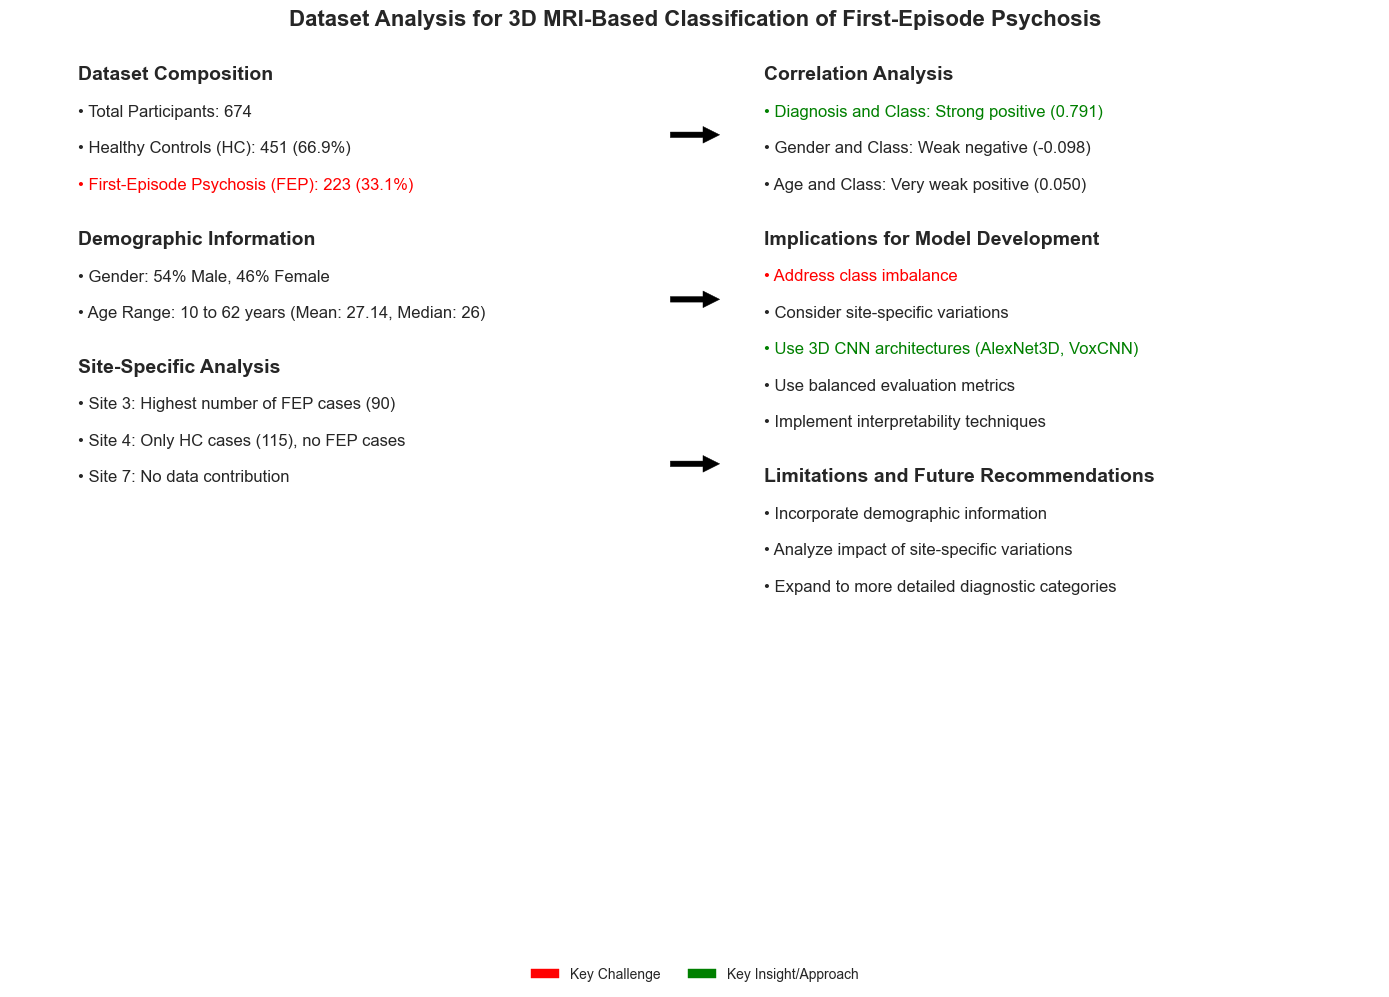

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Title
plt.title('Dataset Analysis for 3D MRI-Based Classification of First-Episode Psychosis', fontsize=16, fontweight='bold')

# Dataset Composition
ax.text(0.05, 0.95, 'Dataset Composition', fontsize=14, fontweight='bold', ha='left')
ax.text(0.05, 0.91, '• Total Participants: 674', fontsize=12, ha='left')
ax.text(0.05, 0.87, '• Healthy Controls (HC): 451 (66.9%)', fontsize=12, ha='left')
ax.text(0.05, 0.83, '• First-Episode Psychosis (FEP): 223 (33.1%)', fontsize=12, ha='left', color='red')

# Demographic Information
ax.text(0.05, 0.77, 'Demographic Information', fontsize=14, fontweight='bold', ha='left')
ax.text(0.05, 0.73, '• Gender: 54% Male, 46% Female', fontsize=12, ha='left')
ax.text(0.05, 0.69, '• Age Range: 10 to 62 years (Mean: 27.14, Median: 26)', fontsize=12, ha='left')

# Site-Specific Analysis
ax.text(0.05, 0.63, 'Site-Specific Analysis', fontsize=14, fontweight='bold', ha='left')
ax.text(0.05, 0.59, '• Site 3: Highest number of FEP cases (90)', fontsize=12, ha='left')
ax.text(0.05, 0.55, '• Site 4: Only HC cases (115), no FEP cases', fontsize=12, ha='left')
ax.text(0.05, 0.51, '• Site 7: No data contribution', fontsize=12, ha='left')

# Correlation Analysis
ax.text(0.55, 0.95, 'Correlation Analysis', fontsize=14, fontweight='bold', ha='left')
ax.text(0.55, 0.91, '• Diagnosis and Class: Strong positive (0.791)', fontsize=12, ha='left', color='green')
ax.text(0.55, 0.87, '• Gender and Class: Weak negative (-0.098)', fontsize=12, ha='left')
ax.text(0.55, 0.83, '• Age and Class: Very weak positive (0.050)', fontsize=12, ha='left')

# Implications for Model Development
ax.text(0.55, 0.77, 'Implications for Model Development', fontsize=14, fontweight='bold', ha='left')
ax.text(0.55, 0.73, '• Address class imbalance', fontsize=12, ha='left', color='red')
ax.text(0.55, 0.69, '• Consider site-specific variations', fontsize=12, ha='left')
ax.text(0.55, 0.65, '• Use 3D CNN architectures (AlexNet3D, VoxCNN)', fontsize=12, ha='left', color='green')
ax.text(0.55, 0.61, '• Use balanced evaluation metrics', fontsize=12, ha='left')
ax.text(0.55, 0.57, '• Implement interpretability techniques', fontsize=12, ha='left')

# Limitations and Future Recommendations
ax.text(0.55, 0.51, 'Limitations and Future Recommendations', fontsize=14, fontweight='bold', ha='left')
ax.text(0.55, 0.47, '• Incorporate demographic information', fontsize=12, ha='left')
ax.text(0.55, 0.43, '• Analyze impact of site-specific variations', fontsize=12, ha='left')
ax.text(0.55, 0.39, '• Expand to more detailed diagnostic categories', fontsize=12, ha='left')

# Arrows to show relationships
ax.annotate('', xy=(0.52, 0.89), xytext=(0.48, 0.89),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(0.52, 0.71), xytext=(0.48, 0.71),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(0.52, 0.53), xytext=(0.48, 0.53),
            arrowprops=dict(facecolor='black', shrink=0.05))

# Legend
red_patch = mpatches.Patch(color='red', label='Key Challenge')
green_patch = mpatches.Patch(color='green', label='Key Insight/Approach')
plt.legend(handles=[red_patch, green_patch], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout()
plt.savefig('dataset_analysis_summary.png', bbox_inches='tight', dpi=300)
plt.show()

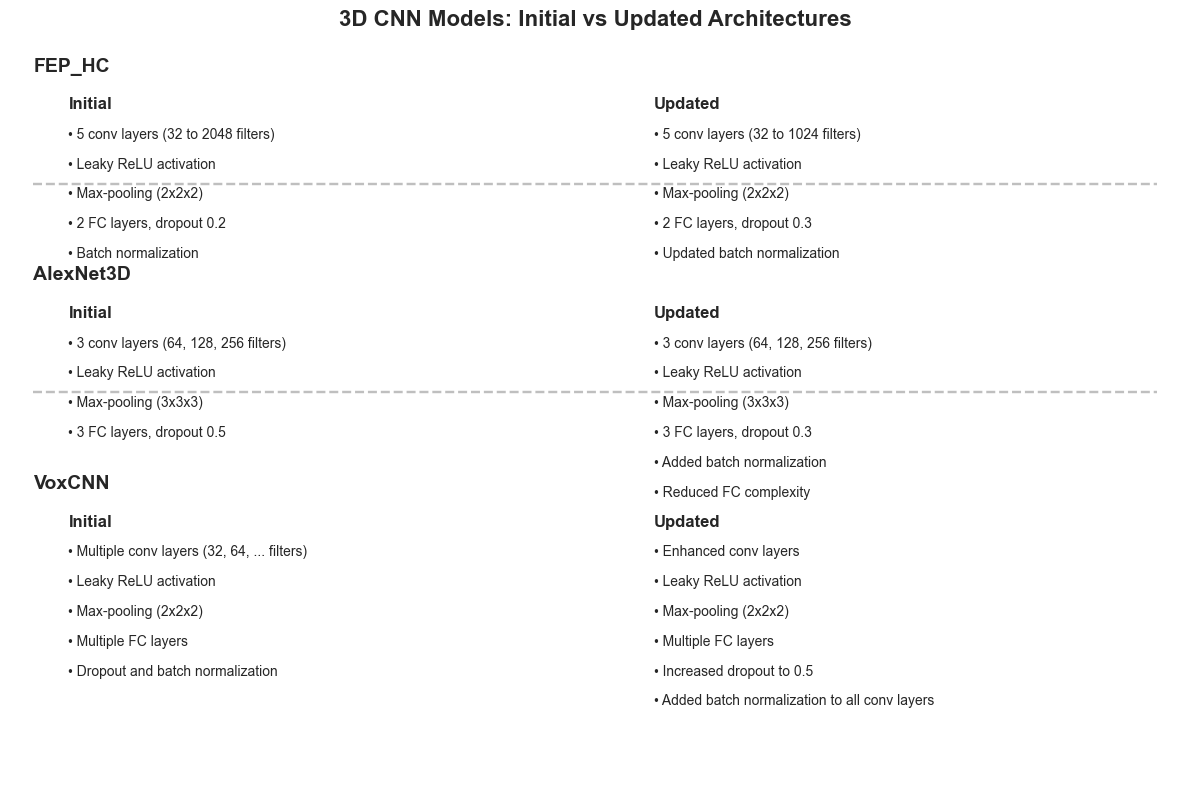

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def create_model_comparison(width, height, models):
    fig, ax = plt.subplots(figsize=(width/100, height/100), dpi=100)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    plt.title('3D CNN Models: Initial vs Updated Architectures', fontsize=16, fontweight='bold')

    y_start = 0.95
    y_step = 0.28

    for i, (model_name, details) in enumerate(models.items()):
        y = y_start - i * y_step
        ax.text(0.02, y, model_name, fontsize=14, fontweight='bold')

        for j, (version, features) in enumerate(details.items()):
            x = 0.05 + j * 0.5
            y_feat = y - 0.05
            ax.text(x, y_feat, version, fontsize=12, fontweight='bold')
            for feature in features:
                y_feat -= 0.04
                ax.text(x, y_feat, f"• {feature}", fontsize=10)

        if i < len(models) - 1:
            ax.axhline(y - 0.15, xmin=0.02, xmax=0.98, color='gray', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('3d_cnn_models_comparison.png', bbox_inches='tight', dpi=300)
    plt.show()

models = {
    "FEP_HC": {
        "Initial": [
            "5 conv layers (32 to 2048 filters)",
            "Leaky ReLU activation",
            "Max-pooling (2x2x2)",
            "2 FC layers, dropout 0.2",
            "Batch normalization"
        ],
        "Updated": [
            "5 conv layers (32 to 1024 filters)",
            "Leaky ReLU activation",
            "Max-pooling (2x2x2)",
            "2 FC layers, dropout 0.3",
            "Updated batch normalization"
        ]
    },
    "AlexNet3D": {
        "Initial": [
            "3 conv layers (64, 128, 256 filters)",
            "Leaky ReLU activation",
            "Max-pooling (3x3x3)",
            "3 FC layers, dropout 0.5"
        ],
        "Updated": [
            "3 conv layers (64, 128, 256 filters)",
            "Leaky ReLU activation",
            "Max-pooling (3x3x3)",
            "3 FC layers, dropout 0.3",
            "Added batch normalization",
            "Reduced FC complexity"
        ]
    },
    "VoxCNN": {
        "Initial": [
            "Multiple conv layers (32, 64, ... filters)",
            "Leaky ReLU activation",
            "Max-pooling (2x2x2)",
            "Multiple FC layers",
            "Dropout and batch normalization"
        ],
        "Updated": [
            "Enhanced conv layers",
            "Leaky ReLU activation",
            "Max-pooling (2x2x2)",
            "Multiple FC layers",
            "Increased dropout to 0.5",
            "Added batch normalization to all conv layers"
        ]
    }
}

create_model_comparison(1200, 800, models)

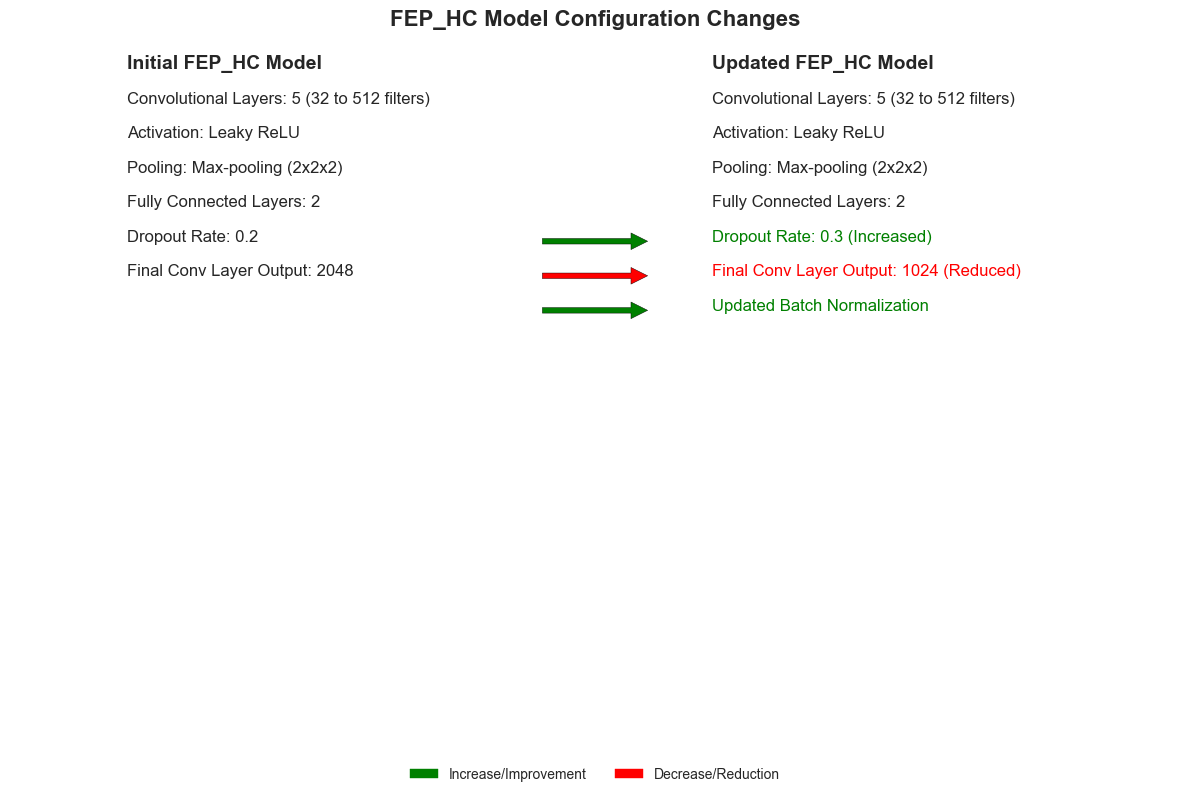

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Title
plt.title('FEP_HC Model Configuration Changes', fontsize=16, fontweight='bold')

# Original Model
ax.text(0.1, 0.95, 'Initial FEP_HC Model', fontsize=14, fontweight='bold', ha='left')
ax.text(0.1, 0.90, 'Convolutional Layers: 5 (32 to 512 filters)', fontsize=12, ha='left')
ax.text(0.1, 0.85, 'Activation: Leaky ReLU', fontsize=12, ha='left')
ax.text(0.1, 0.80, 'Pooling: Max-pooling (2x2x2)', fontsize=12, ha='left')
ax.text(0.1, 0.75, 'Fully Connected Layers: 2', fontsize=12, ha='left')
ax.text(0.1, 0.70, 'Dropout Rate: 0.2', fontsize=12, ha='left')
ax.text(0.1, 0.65, 'Final Conv Layer Output: 2048', fontsize=12, ha='left')

# Updated Model
ax.text(0.6, 0.95, 'Updated FEP_HC Model', fontsize=14, fontweight='bold', ha='left')
ax.text(0.6, 0.90, 'Convolutional Layers: 5 (32 to 512 filters)', fontsize=12, ha='left')
ax.text(0.6, 0.85, 'Activation: Leaky ReLU', fontsize=12, ha='left')
ax.text(0.6, 0.80, 'Pooling: Max-pooling (2x2x2)', fontsize=12, ha='left')
ax.text(0.6, 0.75, 'Fully Connected Layers: 2', fontsize=12, ha='left')
ax.text(0.6, 0.70, 'Dropout Rate: 0.3 (Increased)', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.65, 'Final Conv Layer Output: 1024 (Reduced)', fontsize=12, ha='left', color='red')
ax.text(0.6, 0.60, 'Updated Batch Normalization', fontsize=12, ha='left', color='green')

# Arrows and annotations to indicate changes
ax.annotate('', xy=(0.55, 0.70), xytext=(0.45, 0.70),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.65), xytext=(0.45, 0.65),
            arrowprops=dict(facecolor='red', shrink=0.05))
ax.annotate('', xy=(0.55, 0.60), xytext=(0.45, 0.60),
            arrowprops=dict(facecolor='green', shrink=0.05))

# Legend
green_patch = mpatches.Patch(color='green', label='Increase/Improvement')
red_patch = mpatches.Patch(color='red', label='Decrease/Reduction')
plt.legend(handles=[green_patch, red_patch], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
plt.savefig('fep_hc_model_configuration_changes.png', bbox_inches='tight')
plt.show()

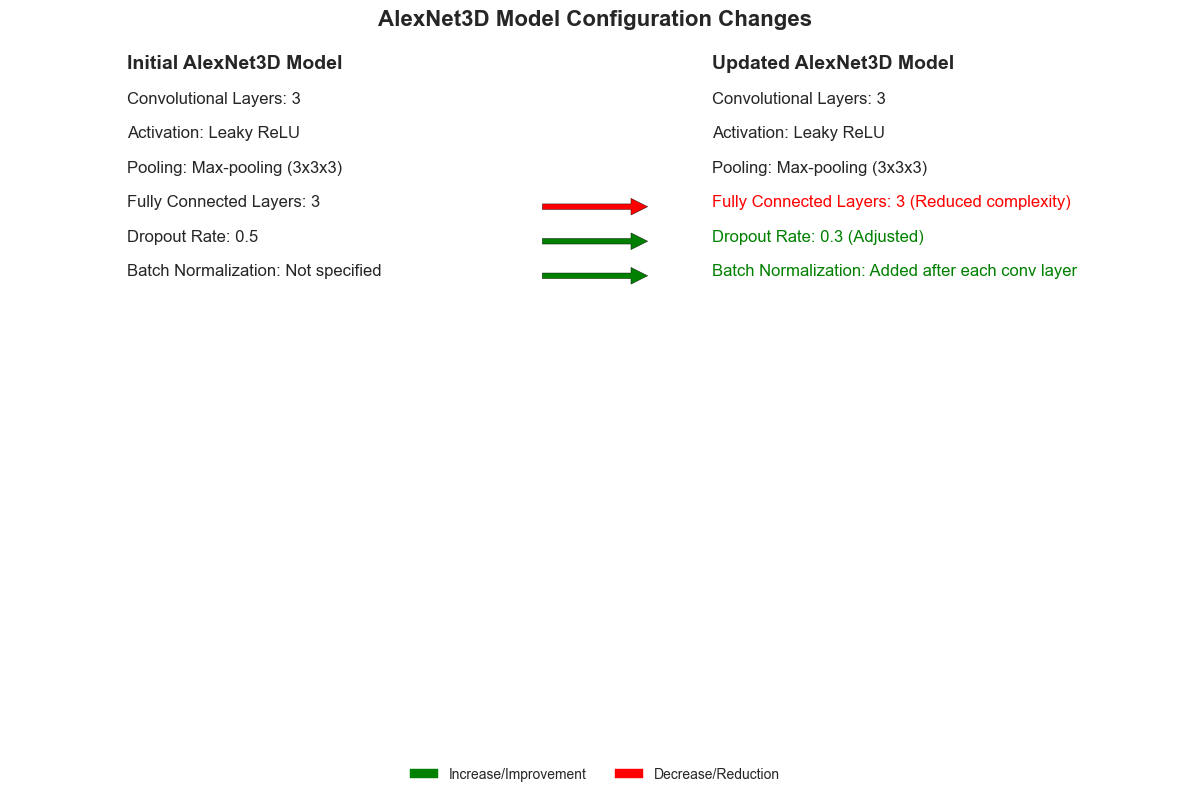

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Title
plt.title('AlexNet3D Model Configuration Changes', fontsize=16, fontweight='bold')

# Original Model
ax.text(0.1, 0.95, 'Initial AlexNet3D Model', fontsize=14, fontweight='bold', ha='left')
ax.text(0.1, 0.90, 'Convolutional Layers: 3', fontsize=12, ha='left')
ax.text(0.1, 0.85, 'Activation: Leaky ReLU', fontsize=12, ha='left')
ax.text(0.1, 0.80, 'Pooling: Max-pooling (3x3x3)', fontsize=12, ha='left')
ax.text(0.1, 0.75, 'Fully Connected Layers: 3', fontsize=12, ha='left')
ax.text(0.1, 0.70, 'Dropout Rate: 0.5', fontsize=12, ha='left')
ax.text(0.1, 0.65, 'Batch Normalization: Not specified', fontsize=12, ha='left')

# Updated Model
ax.text(0.6, 0.95, 'Updated AlexNet3D Model', fontsize=14, fontweight='bold', ha='left')
ax.text(0.6, 0.90, 'Convolutional Layers: 3', fontsize=12, ha='left')
ax.text(0.6, 0.85, 'Activation: Leaky ReLU', fontsize=12, ha='left')
ax.text(0.6, 0.80, 'Pooling: Max-pooling (3x3x3)', fontsize=12, ha='left')
ax.text(0.6, 0.75, 'Fully Connected Layers: 3 (Reduced complexity)', fontsize=12, ha='left', color='red')
ax.text(0.6, 0.70, 'Dropout Rate: 0.3 (Adjusted)', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.65, 'Batch Normalization: Added after each conv layer', fontsize=12, ha='left', color='green')

# Arrows and annotations to indicate changes
ax.annotate('', xy=(0.55, 0.75), xytext=(0.45, 0.75),
            arrowprops=dict(facecolor='red', shrink=0.05))
ax.annotate('', xy=(0.55, 0.70), xytext=(0.45, 0.70),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.65), xytext=(0.45, 0.65),
            arrowprops=dict(facecolor='green', shrink=0.05))

# Legend
green_patch = mpatches.Patch(color='green', label='Increase/Improvement')
red_patch = mpatches.Patch(color='red', label='Decrease/Reduction')
plt.legend(handles=[green_patch, red_patch], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
plt.savefig('alexnet3d_model_configuration_changes.png', bbox_inches='tight')
plt.show()

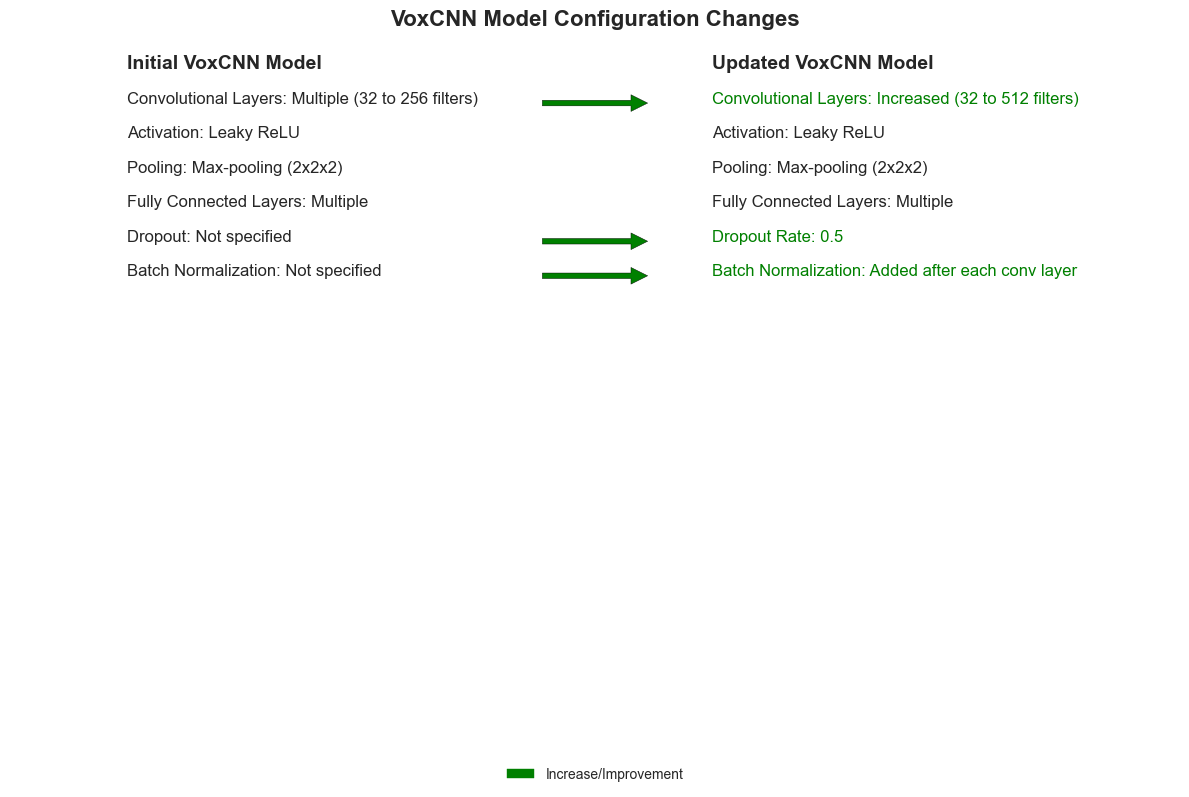

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Title
plt.title('VoxCNN Model Configuration Changes', fontsize=16, fontweight='bold')

# Original Model
ax.text(0.1, 0.95, 'Initial VoxCNN Model', fontsize=14, fontweight='bold', ha='left')
ax.text(0.1, 0.90, 'Convolutional Layers: Multiple (32 to 256 filters)', fontsize=12, ha='left')
ax.text(0.1, 0.85, 'Activation: Leaky ReLU', fontsize=12, ha='left')
ax.text(0.1, 0.80, 'Pooling: Max-pooling (2x2x2)', fontsize=12, ha='left')
ax.text(0.1, 0.75, 'Fully Connected Layers: Multiple', fontsize=12, ha='left')
ax.text(0.1, 0.70, 'Dropout: Not specified', fontsize=12, ha='left')
ax.text(0.1, 0.65, 'Batch Normalization: Not specified', fontsize=12, ha='left')

# Updated Model
ax.text(0.6, 0.95, 'Updated VoxCNN Model', fontsize=14, fontweight='bold', ha='left')
ax.text(0.6, 0.90, 'Convolutional Layers: Increased (32 to 512 filters)', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.85, 'Activation: Leaky ReLU', fontsize=12, ha='left')
ax.text(0.6, 0.80, 'Pooling: Max-pooling (2x2x2)', fontsize=12, ha='left')
ax.text(0.6, 0.75, 'Fully Connected Layers: Multiple', fontsize=12, ha='left')
ax.text(0.6, 0.70, 'Dropout Rate: 0.5', fontsize=12, ha='left', color='green')
ax.text(0.6, 0.65, 'Batch Normalization: Added after each conv layer', fontsize=12, ha='left', color='green')

# Arrows and annotations to indicate changes
ax.annotate('', xy=(0.55, 0.90), xytext=(0.45, 0.90),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.70), xytext=(0.45, 0.70),
            arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate('', xy=(0.55, 0.65), xytext=(0.45, 0.65),
            arrowprops=dict(facecolor='green', shrink=0.05))

# Legend
green_patch = mpatches.Patch(color='green', label='Increase/Improvement')
plt.legend(handles=[green_patch], loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=1)

plt.tight_layout()
plt.savefig('voxcnn_model_configuration_changes.png', bbox_inches='tight')
plt.show()